In [1]:
from visualizations import * 

from matching import Matcher


from matplotlib import pyplot as plt
plt.style.use('ggplot')

from MAG_network import CitationNetwork
import os 
from matplotlib import pyplot as plt
import pandas as pd
import findspark
import MAGspark
import itertools

import sys

import numpy as np
import scipy
from scipy.stats import ks_2samp

sys.path.insert(0,"/home/laal/MAG/CentralityFairness/Evaluations")

Evaluations/lenskit/util.py:45: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @jitclass([


In [2]:
mag, spark = MAGspark.get_mag_with_cluster_connection(jobid=42578, memory_per_executor=14000,
                                                      data_folderpath="/home/laal/MAG/DATA/")

['NAME STATE JOBID', 'simple RUNNING 42586', 'big_runFrost RUNNING 42572', 'big_runFrost RUNNING 42570', 'big_runFrost RUNNING 42575', 'big_runFrost RUNNING 42573', 'sparkcluster RUNNING 42578', 'big_runIsa RUNNING 42588', 'big_runIsa RUNNING 42587', 'jupyter RUNNING 42576', '']


In [3]:
def compute_ks_test(mag, centrality_df, fos_id, base_filepath="/home/laal/MAG/DATA"):
    
    centrality_df[['AuthorId', 'Gender']].to_csv(base_filepath + "/CentralityAuthors.txt", header=False,index=False, sep="\t")
    
    mag.streams['CentralityAuthors'] = ('CentralityAuthors.txt', ['AuthorId:long', 'Gender:int'])
    
    inter_event = mag.getDataframe('InterEventPublications')
    cent_authors = mag.getDataframe('CentralityAuthors')
    
    query = """
        SELECT iep.AuthorId, ca.Gender, iep.DateDiff 
        FROM InterEventPublications  iep
        INNER JOIN CentralityAuthors ca ON iep.AuthorId = ca.AuthorId
        WHERE FieldOfStudyId = {} AND PrevPaperId != CurrentPaperId
    """.format(fos_id)
    
    
    datediffs = mag.query_sql(query).toPandas()
    women_interevent = datediffs.query("Gender == 0")['DateDiff']
    men_interevent = datediffs.query("Gender == 1")['DateDiff']
    
    ks_test = ks_2samp(women_interevent.values, men_interevent.values)
    
    return datediffs, ks_test


def plot_inter_event_cdf(datediffs, ks_test, field_name, filepath=None):
    
    women_interevent = datediffs.query("Gender == 0")['DateDiff']
    men_interevent = datediffs.query("Gender == 1")['DateDiff']

    women_interevent.hist(cumulative=True, density=1, bins=2000, histtype='step', figsize=(12,8), 
                          linewidth=3, color="#6fc9f2", label="Women")

    men_interevent.hist(cumulative=True, density=1, bins=2000, histtype='step', linewidth=3, 
                        label="Men", color="#bd8aff")

    plt.xlim(-100, 2500)
    plt.ylim(0.0, 1.05)

    title = "{}:\nCDF: Number of days since previous publishing date".format(field_name)
    title += "\n KS statistic: {0:.3f}".format(ks_test.statistic) + ", p-value: {0:.3f}".format(ks_test.pvalue)
    
    plt.title(title)
    plt.xlabel('Number of days')
    plt.ylabel('Cumulative probability')
    plt.legend(loc="right")
    
    if filepath is not None:
        plt.savefig(filepath)
        
    plt.show()
    
    

def plot_centrality_correlations(field_name, matched_data, filename=None):

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10), sharex=False, sharey=False)
    axs = list(axs.flatten())
    
    idx = 0
    
    matched_data['MAG Rank'] = 1 / matched_data['Rank'] 
    
    CENTRALITIES = ['PageRank', 'PageRank05', 'InDegreeStrength', 'MAG Rank']
    
    for cent1, cent2 in itertools.combinations(CENTRALITIES, r=2):
    
        corr = scipy.stats.pearsonr(matched_data[cent1], matched_data[cent2])
        axs[idx].scatter(x=matched_data[cent1], y=matched_data[cent2], alpha=0.3)
        axs[idx].set_title("{} vs. {}".format( cent1, cent2 ) + "\n Corr = {0:.3f}, p-value=".format(corr[0]) + "{0:.3f}".format(corr[1]))
        axs[idx].set_ylabel(cent2)
        axs[idx].set_xlabel(cent1)
        
        idx += 1


    plt.suptitle('Centrality correlations for matched population: {}'.format(field_name), fontsize=16)
    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)
    plt.show()

--------------------------------STARTING VIZ ON ECONOMICS-----------------------------


gender counts before query:

1    172457
0     70645
Name: Gender, dtype: int64
Men with more than 1 paper:  (93686, 12)
Women with more than 1 paper:  (32767, 12)


/home/laal/MAG/CentralityFairness/visualizations.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks)
/home/laal/MAG/CentralityFairness/visualizations.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks)


Full data median: 63226.0
Random data median: 66197.5
Matched data median: 71936.5


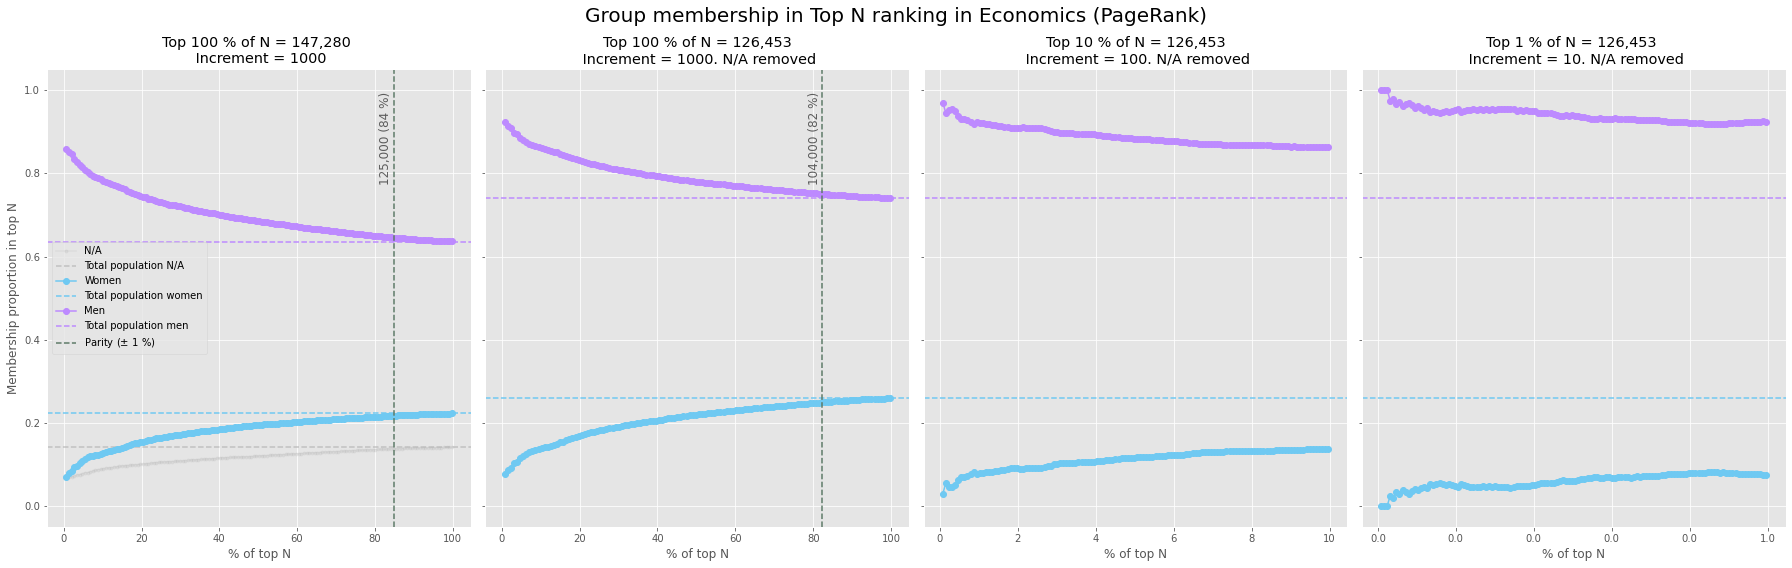

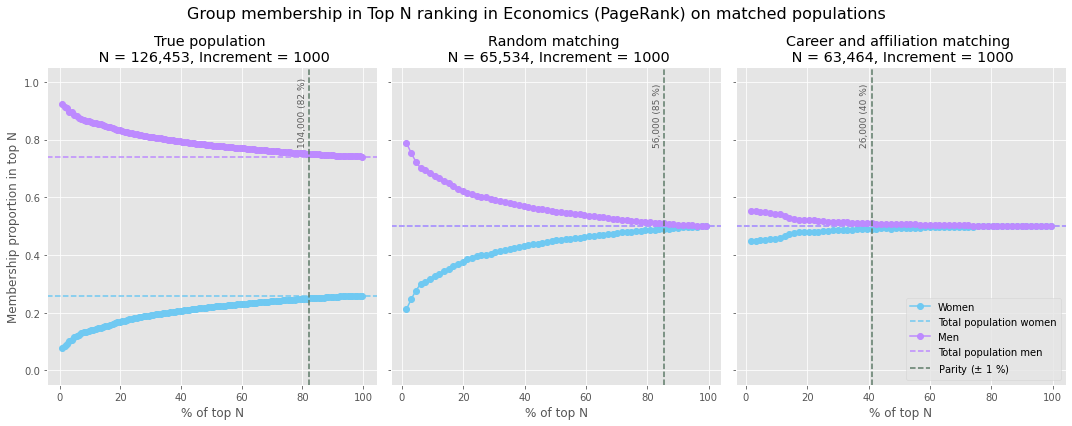

/home/laal/MAG/CentralityFairness/visualizations.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks)
/home/laal/MAG/CentralityFairness/visualizations.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks)


Full data median: 63226.0
Random data median: 65908.0
Matched data median: 71476.5


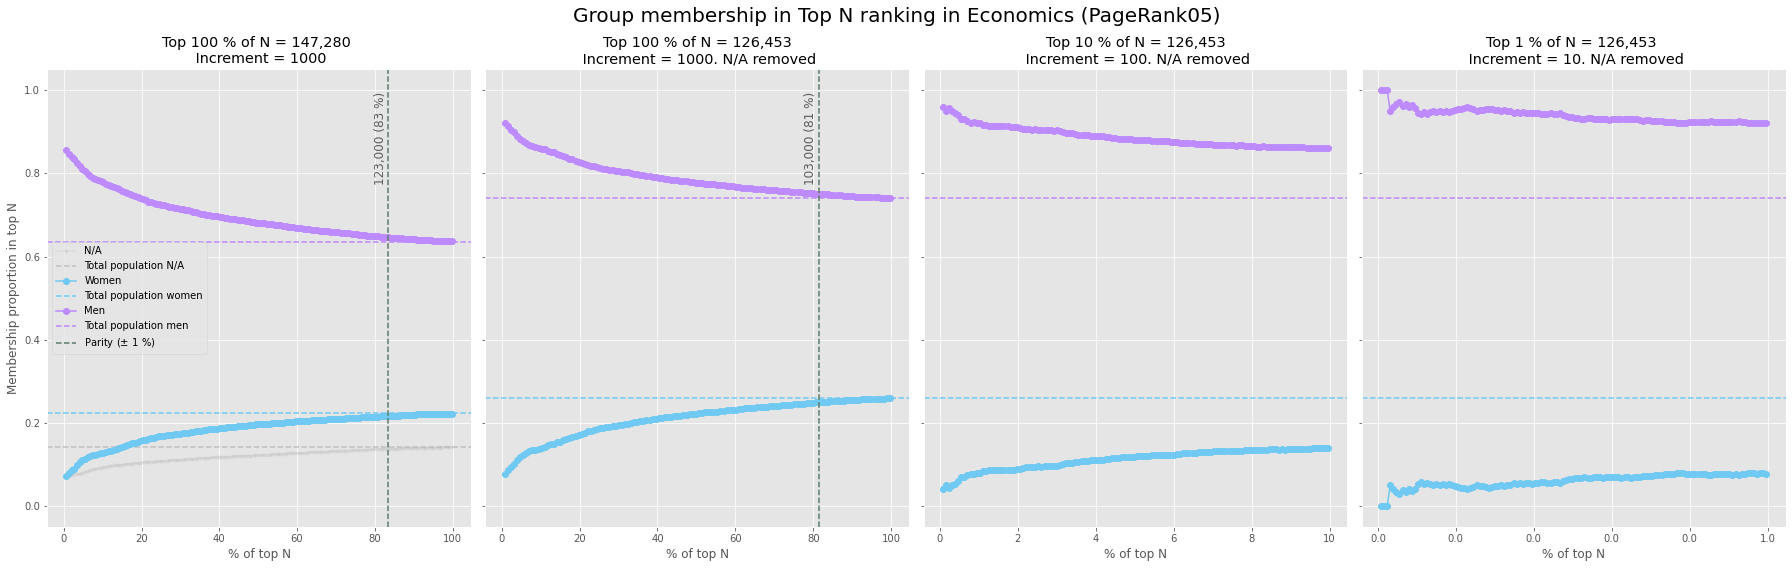

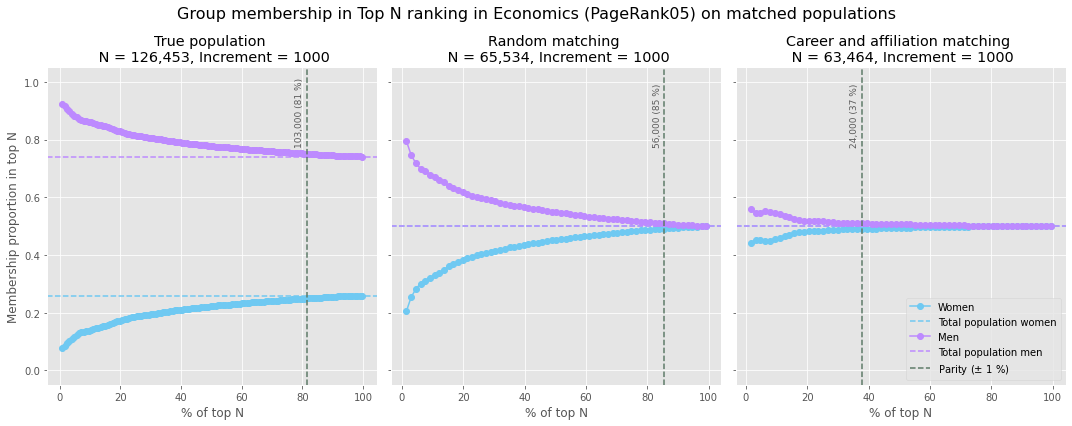

/home/laal/MAG/CentralityFairness/visualizations.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks)
/home/laal/MAG/CentralityFairness/visualizations.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks)


Full data median: 63226.0
Random data median: 65757.5
Matched data median: 70437.5


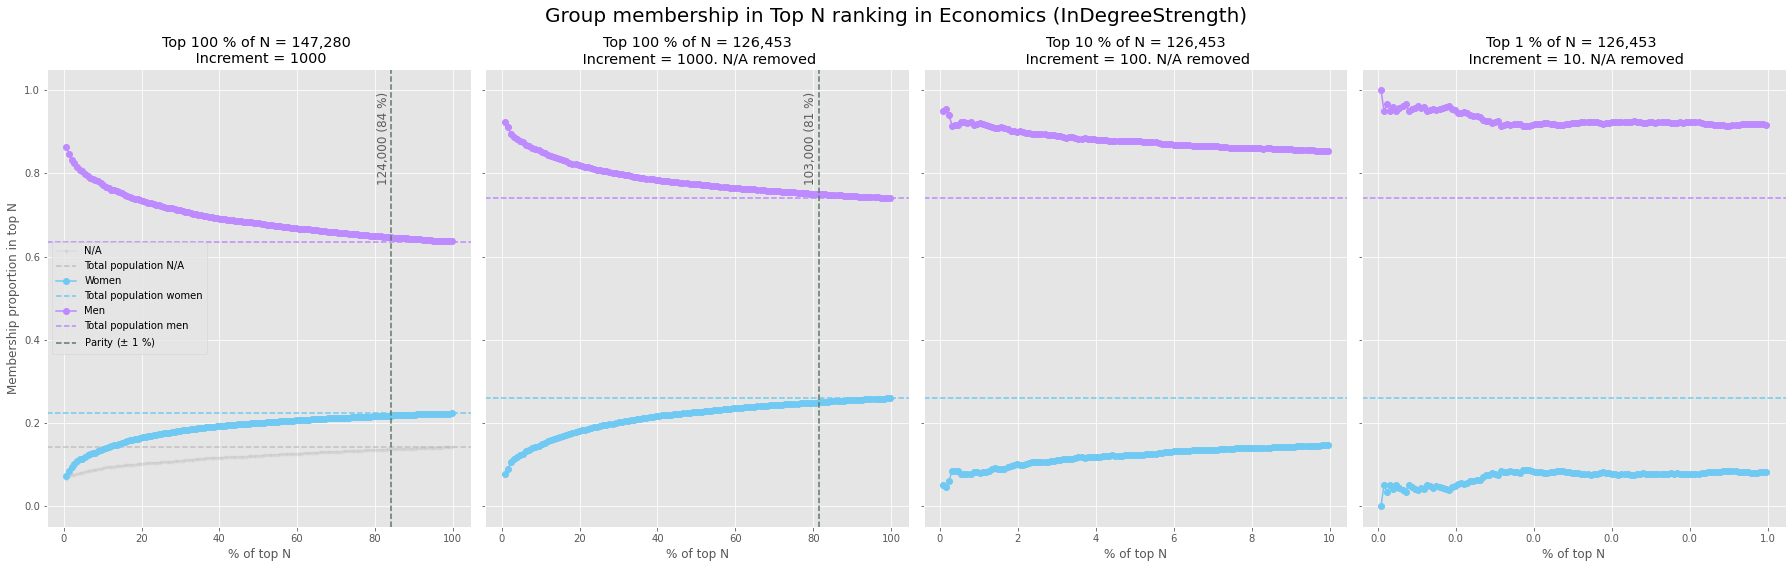

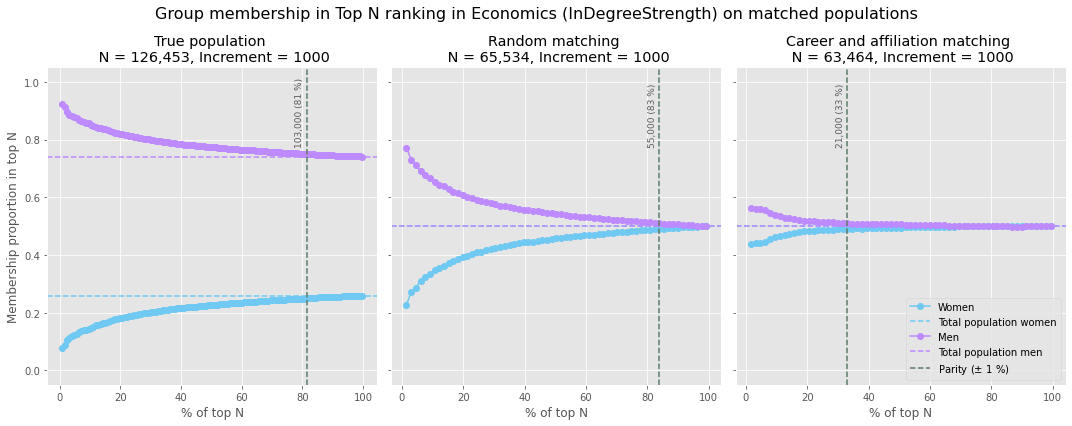

/home/laal/MAG/CentralityFairness/visualizations.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks)
/home/laal/MAG/CentralityFairness/visualizations.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks)


Full data median: 63226.0
Random data median: 65890.0
Matched data median: 68236.5


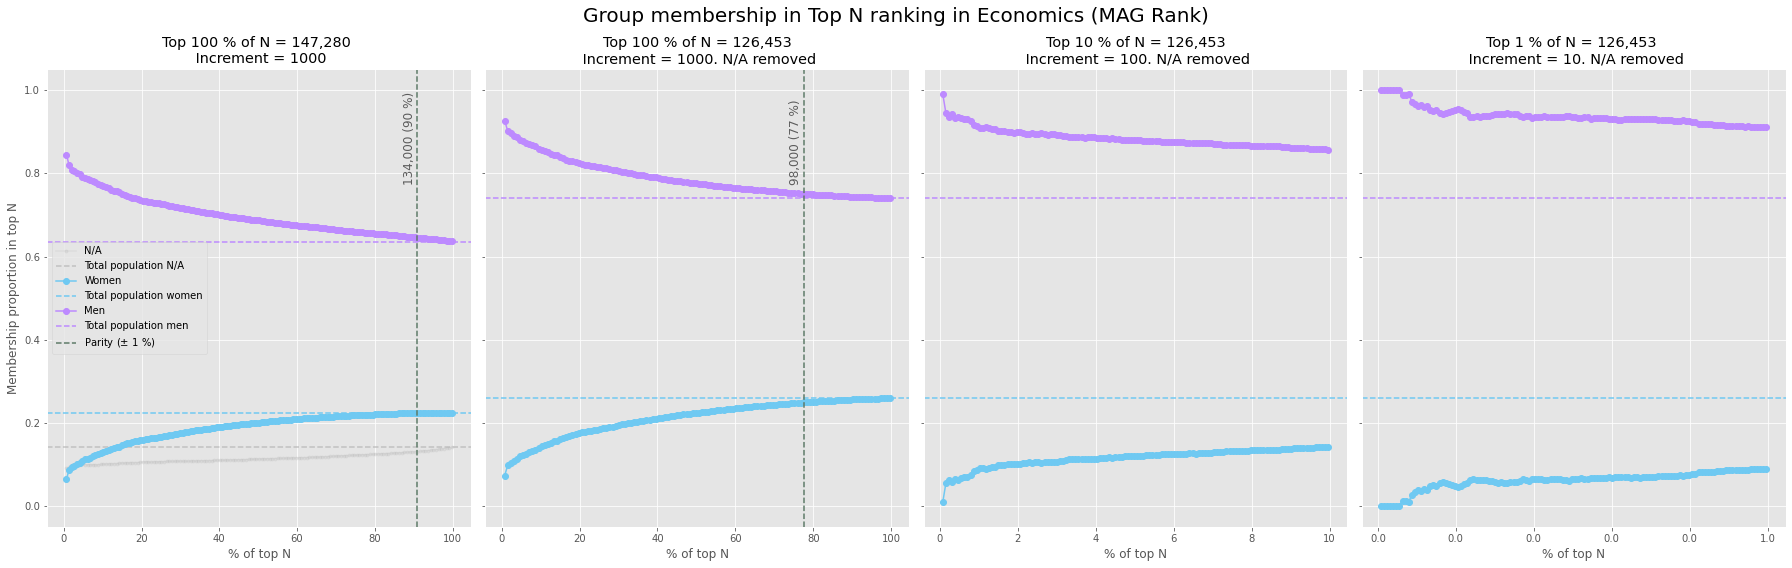

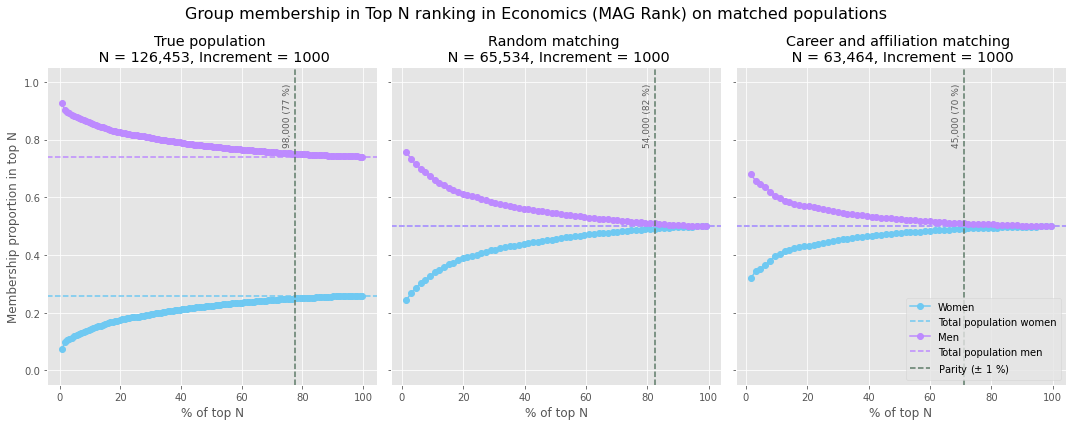

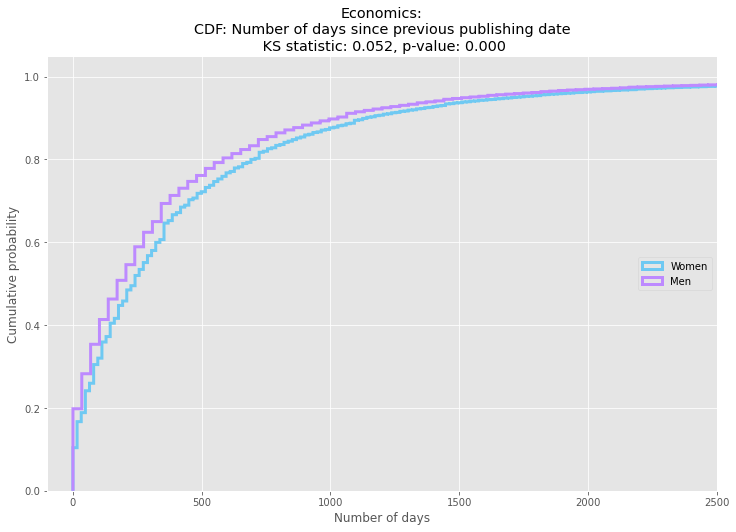

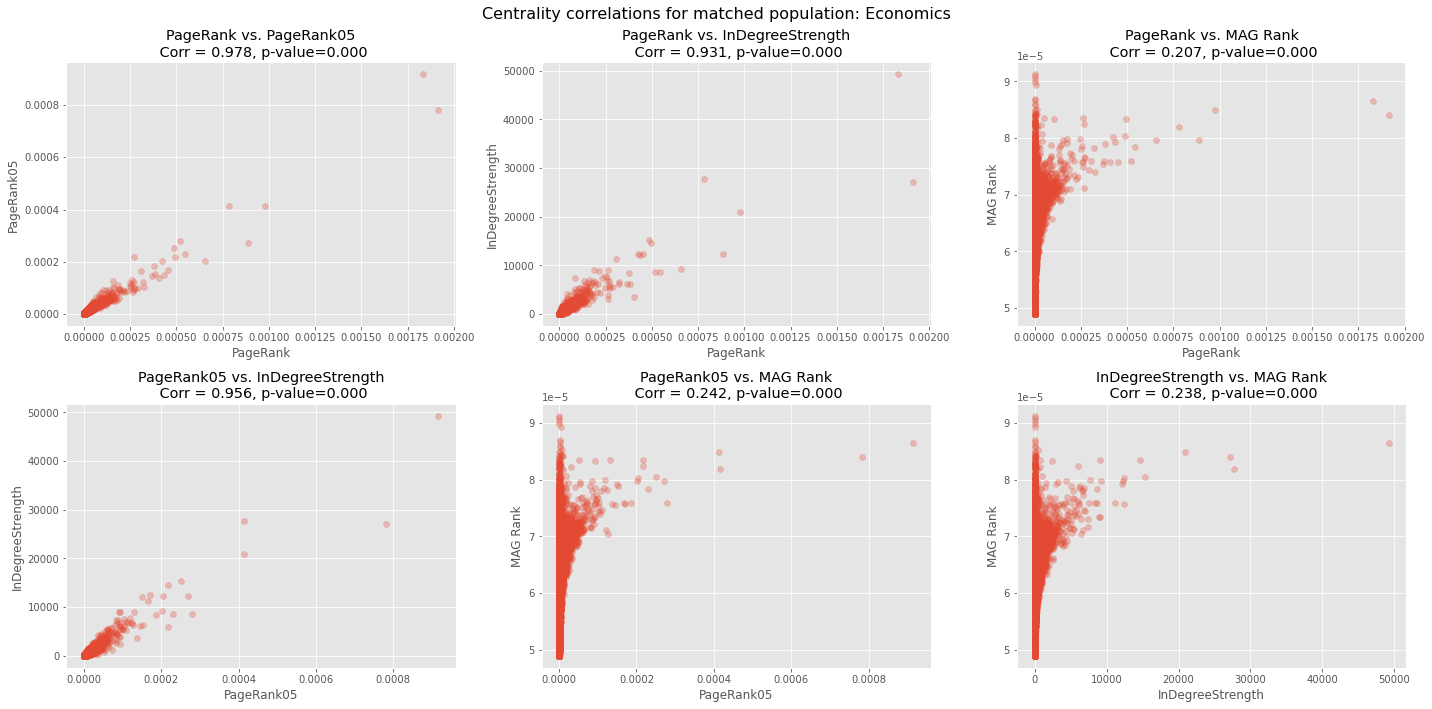

--------------------------------STARTING VIZ ON PSYCHOLOGY-----------------------------


gender counts before query:

0    526594
1    480539
Name: Gender, dtype: int64
Men with more than 1 paper:  (247854, 12)
Women with more than 1 paper:  (255609, 12)


/home/laal/MAG/CentralityFairness/visualizations.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks)
/home/laal/MAG/CentralityFairness/visualizations.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks)


Full data median: 251731.0
Random data median: 251501.5
Matched data median: 261951.5


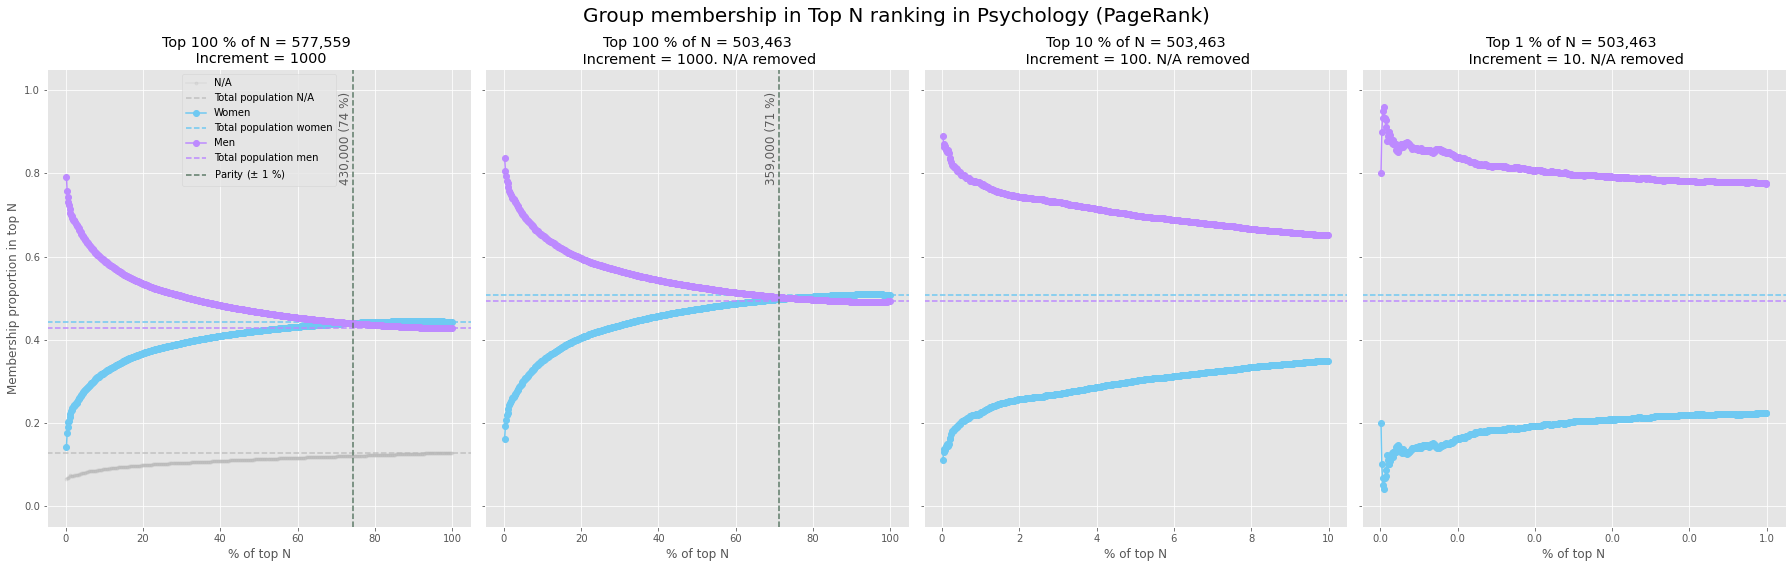

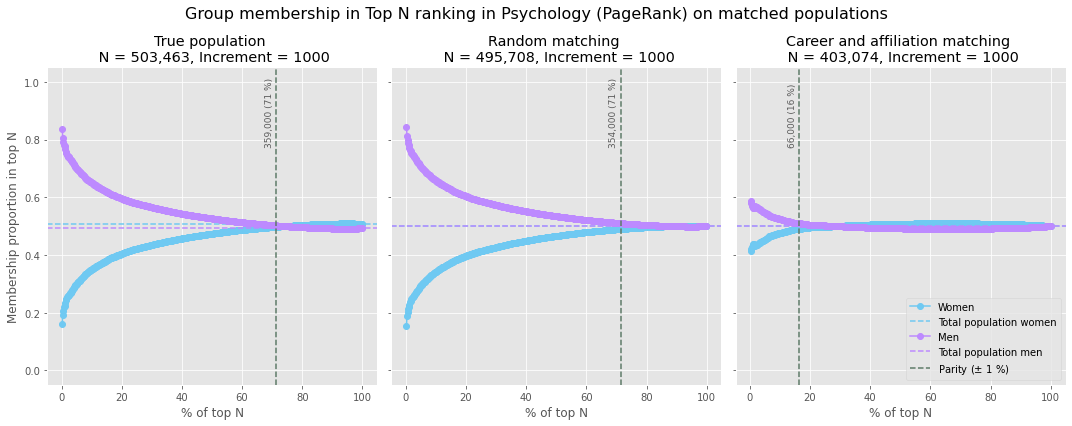

/home/laal/MAG/CentralityFairness/visualizations.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks)
/home/laal/MAG/CentralityFairness/visualizations.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks)


Full data median: 251731.0
Random data median: 251524.5
Matched data median: 260423.5


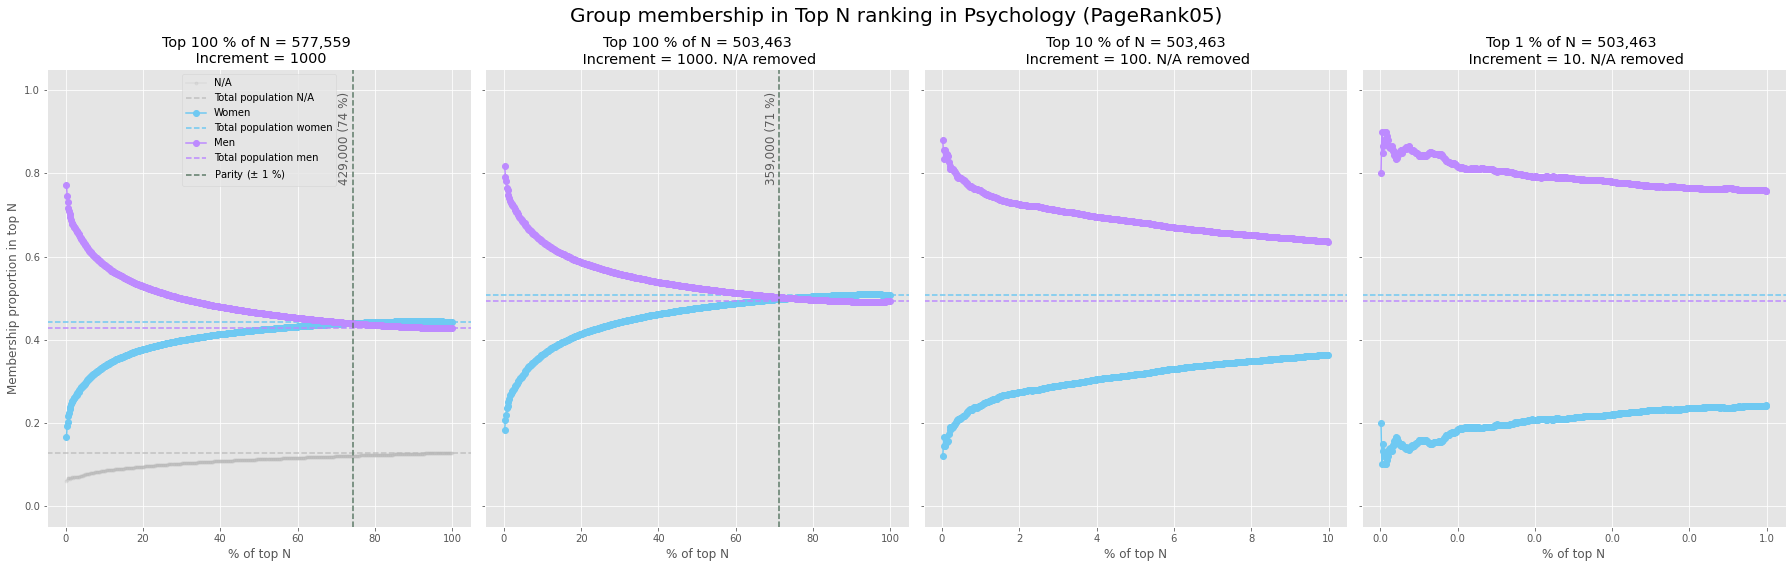

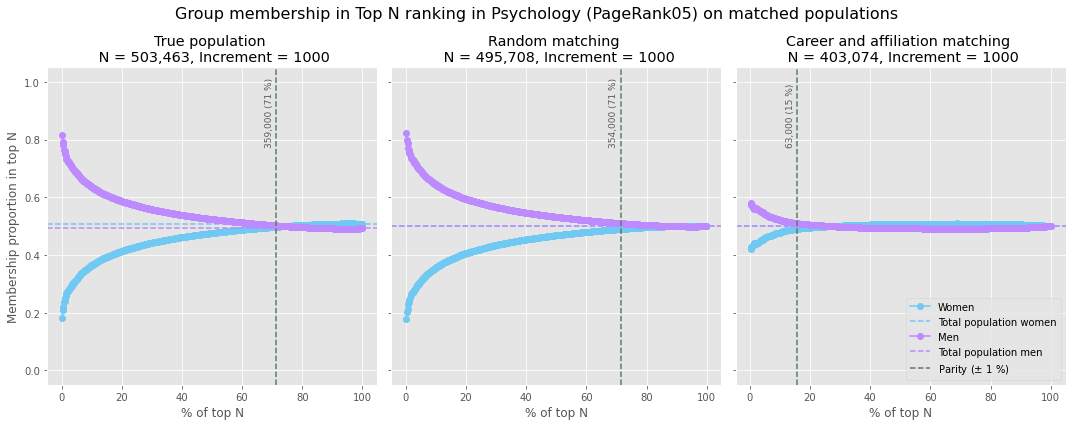

/home/laal/MAG/CentralityFairness/visualizations.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks)
/home/laal/MAG/CentralityFairness/visualizations.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks)


Full data median: 251731.0
Random data median: 251666.5
Matched data median: 259451.5


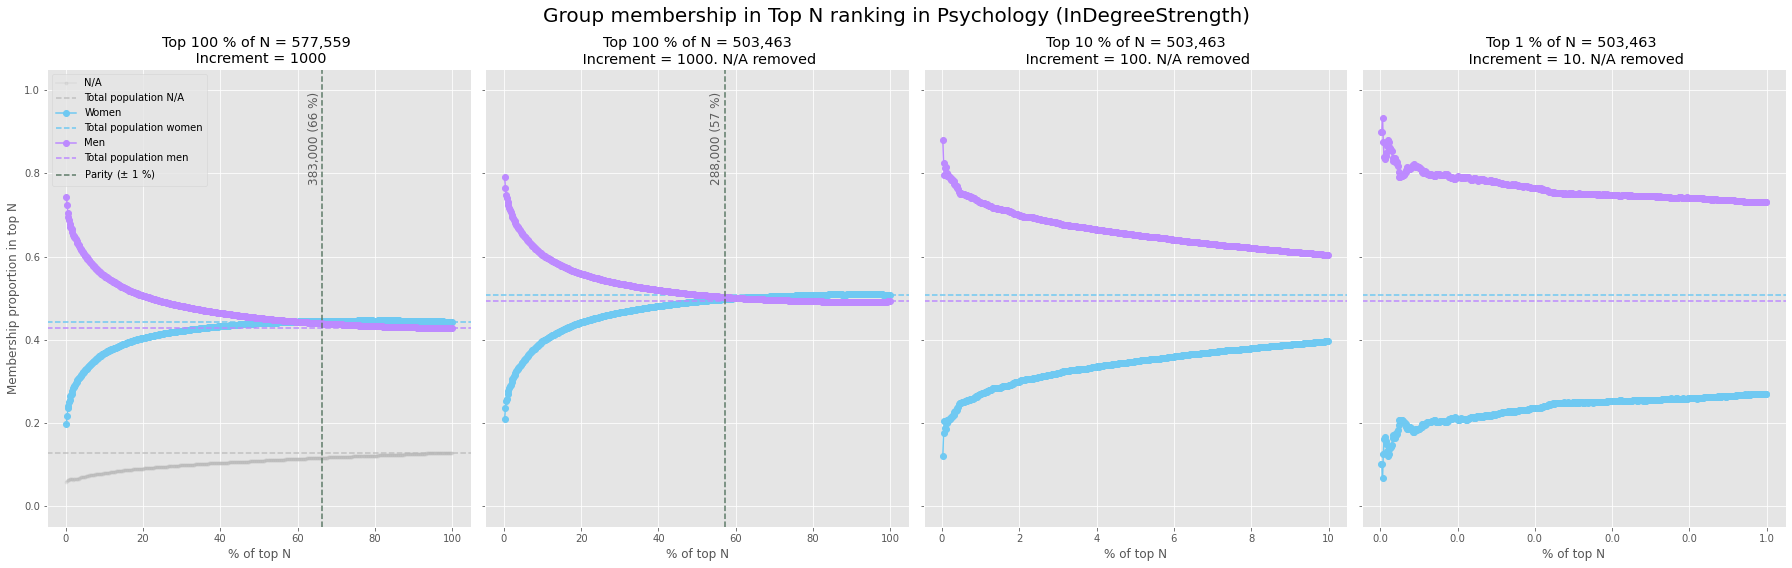

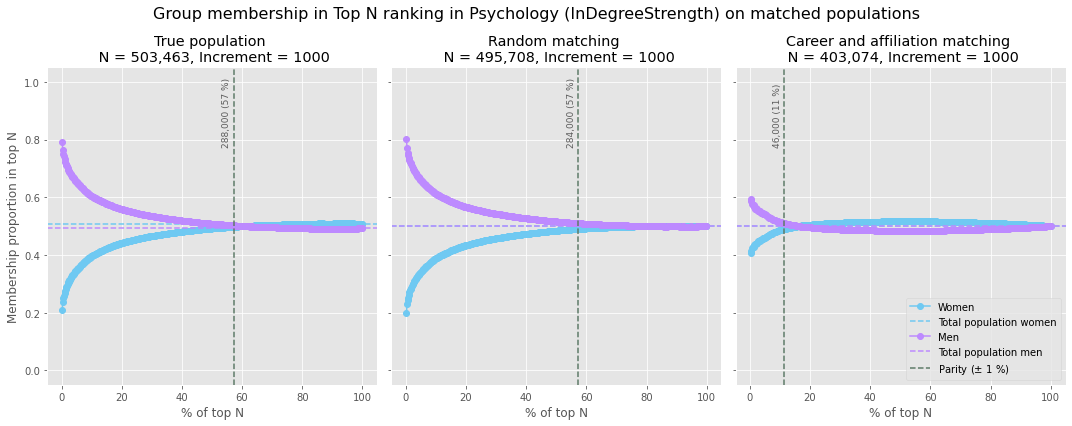

/home/laal/MAG/CentralityFairness/visualizations.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks)
/home/laal/MAG/CentralityFairness/visualizations.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks)


Full data median: 251731.0
Random data median: 251113.5
Matched data median: 247521.0


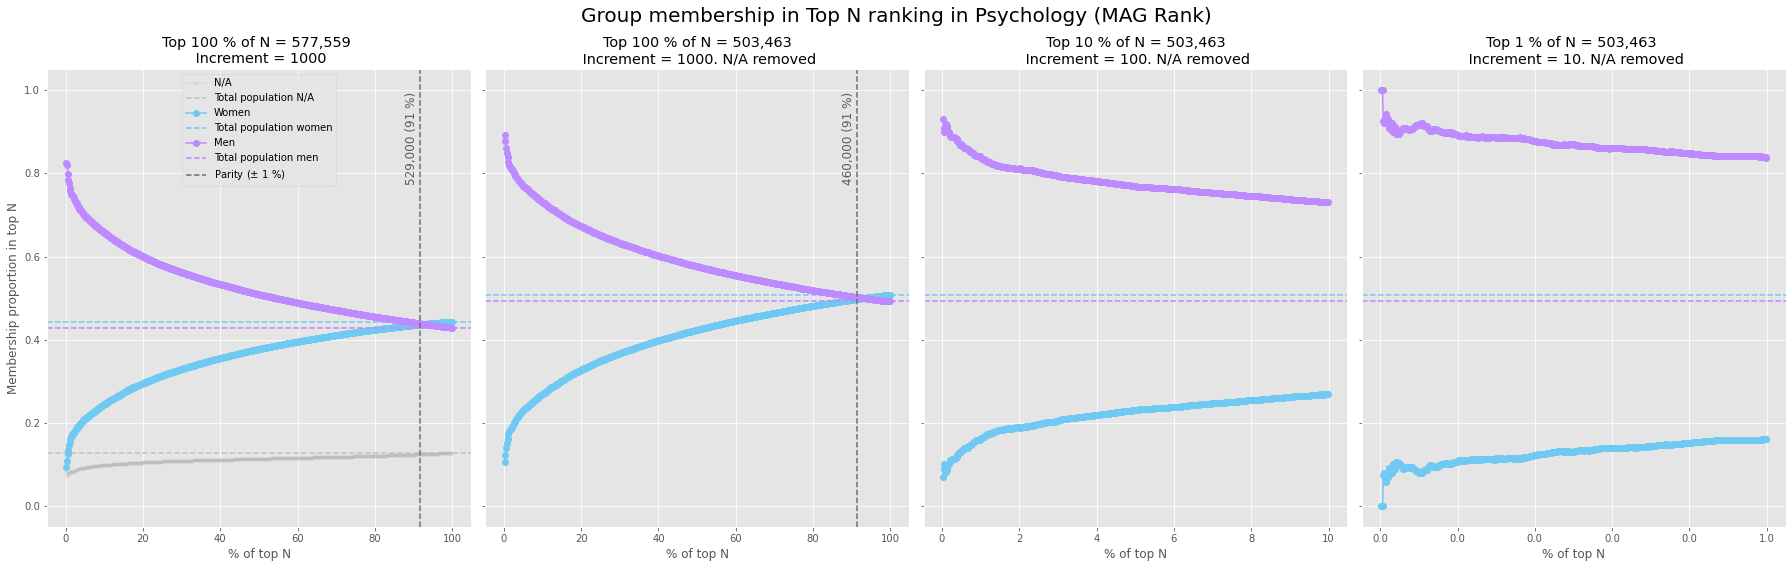

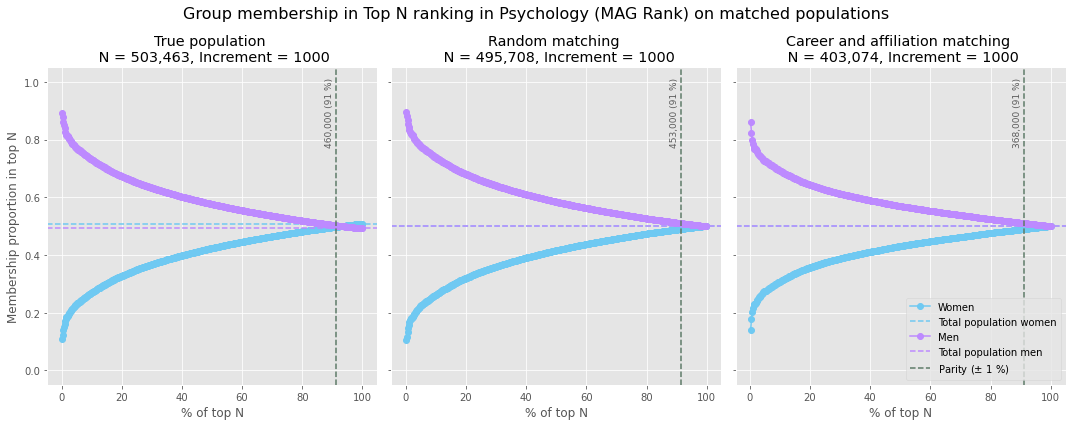

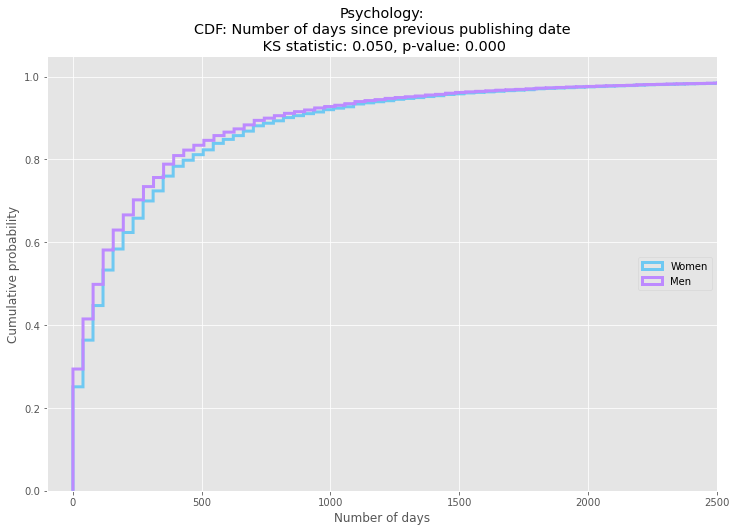

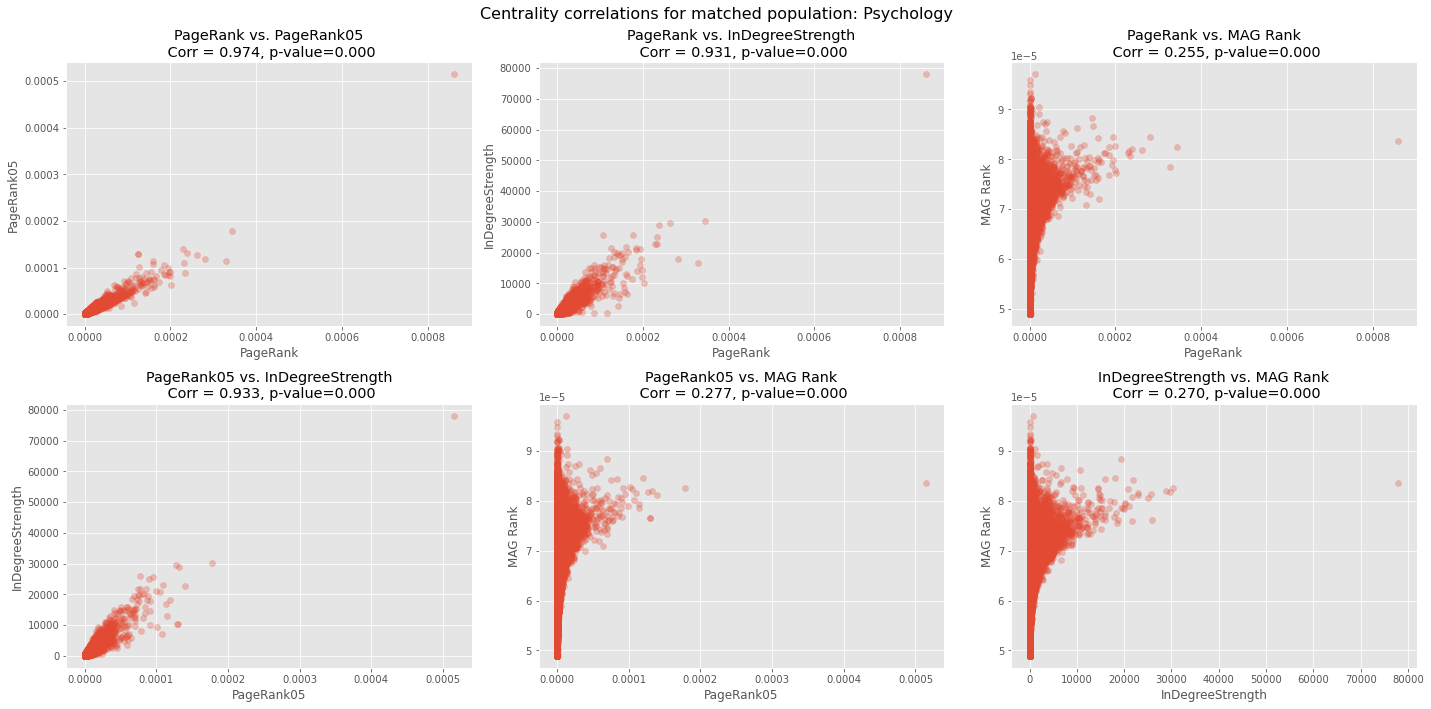

--------------------------------STARTING VIZ ON MATHEMATICS-----------------------------


gender counts before query:

1    500113
0    154212
Name: Gender, dtype: int64
Men with more than 1 paper:  (257876, 12)
Women with more than 1 paper:  (67539, 12)


/home/laal/MAG/CentralityFairness/visualizations.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks)
/home/laal/MAG/CentralityFairness/visualizations.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks)


Full data median: 162707.0
Random data median: 172887.5
Matched data median: 144033.5


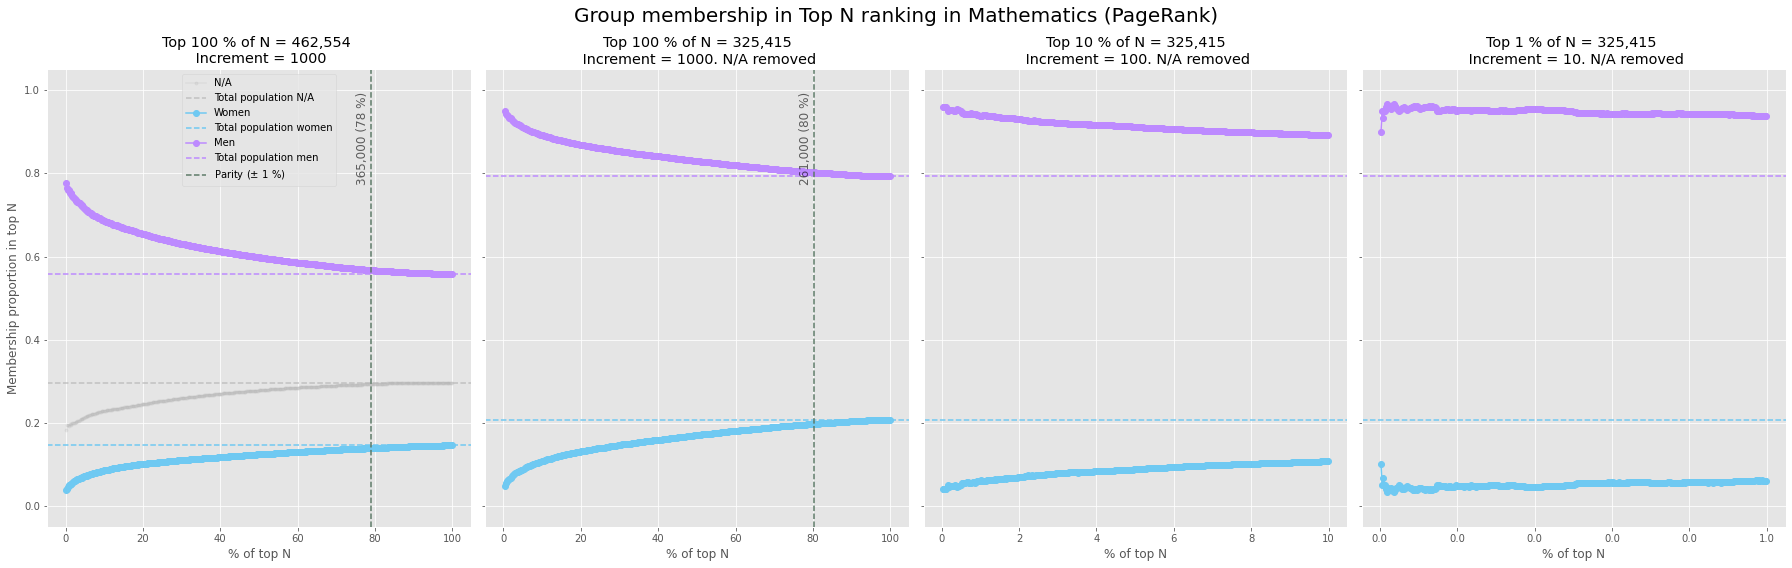

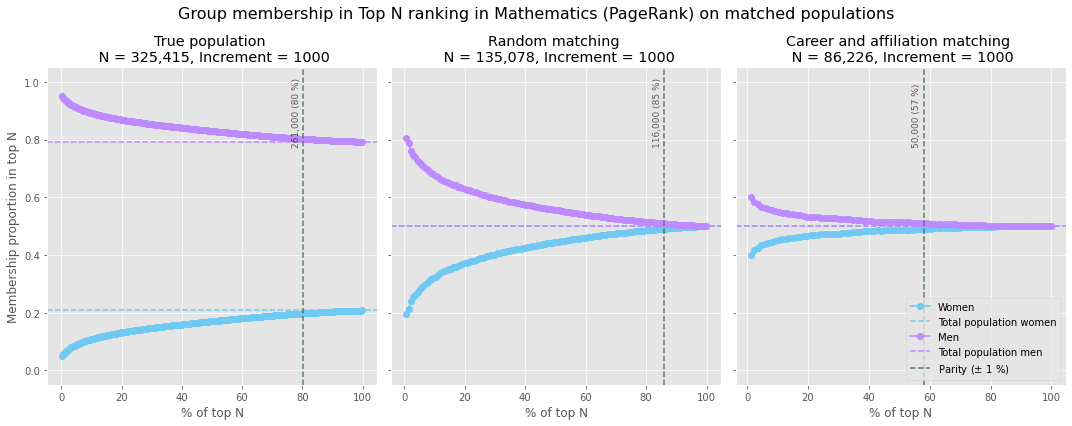

/home/laal/MAG/CentralityFairness/visualizations.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks)
/home/laal/MAG/CentralityFairness/visualizations.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks)


Full data median: 162707.0
Random data median: 172695.5
Matched data median: 144467.5


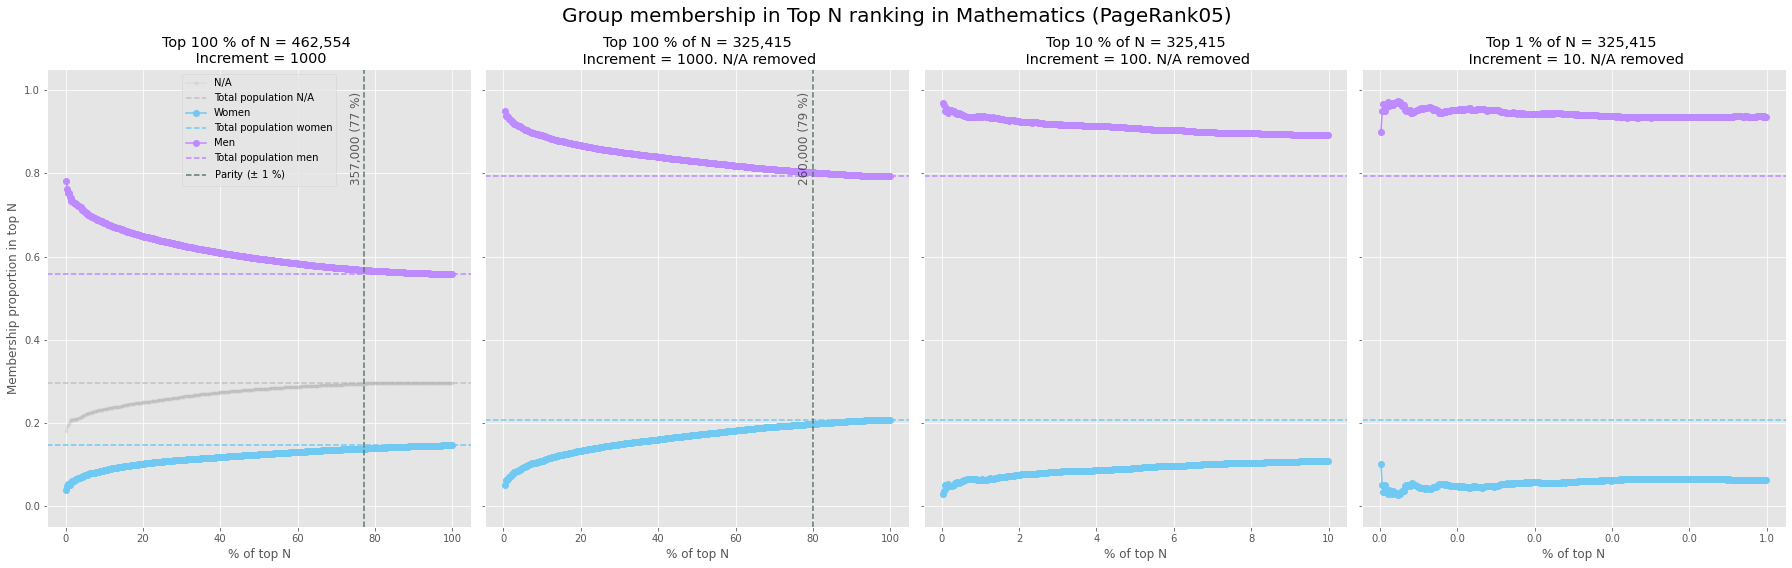

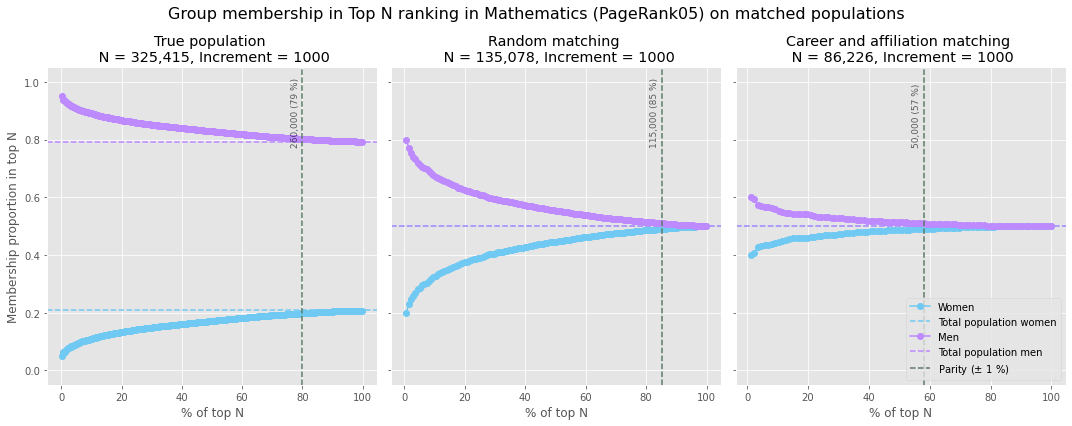

/home/laal/MAG/CentralityFairness/visualizations.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks)
/home/laal/MAG/CentralityFairness/visualizations.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks)


Full data median: 162707.0
Random data median: 169253.5
Matched data median: 144067.0


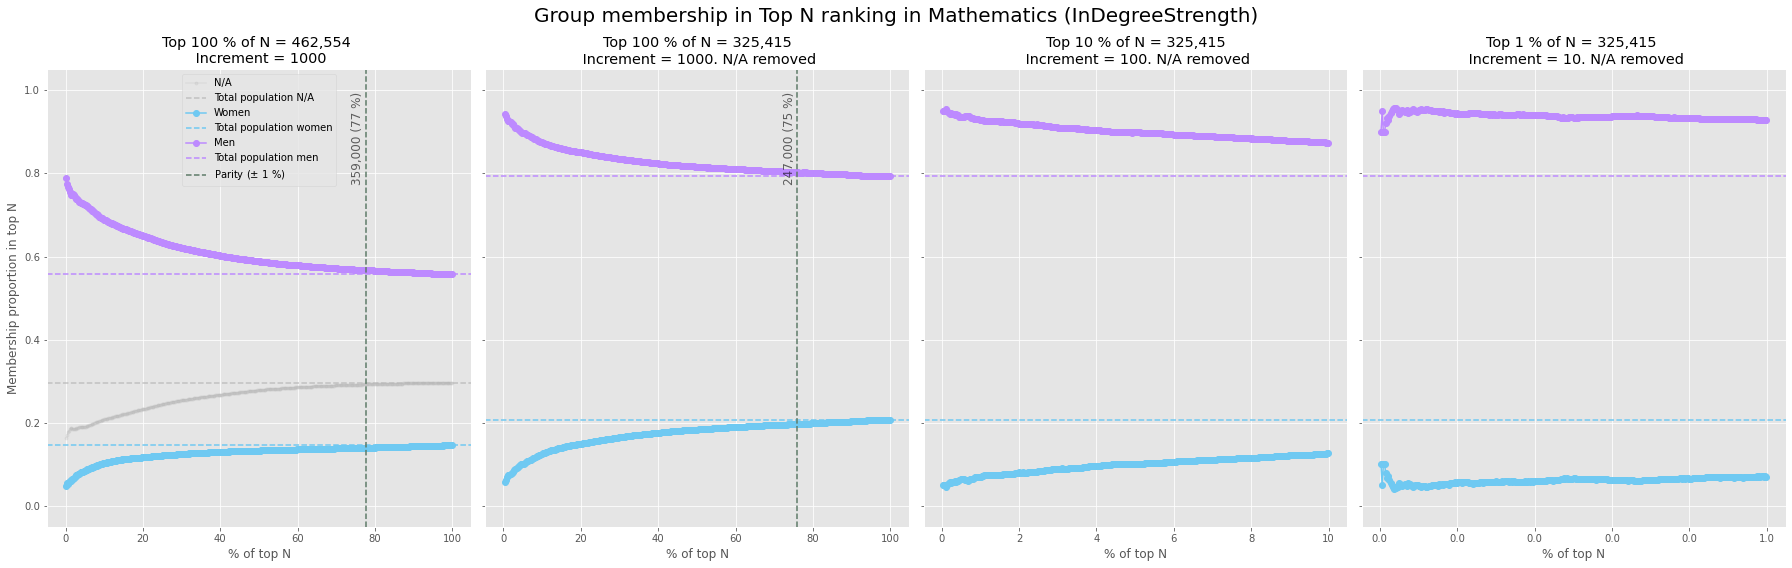

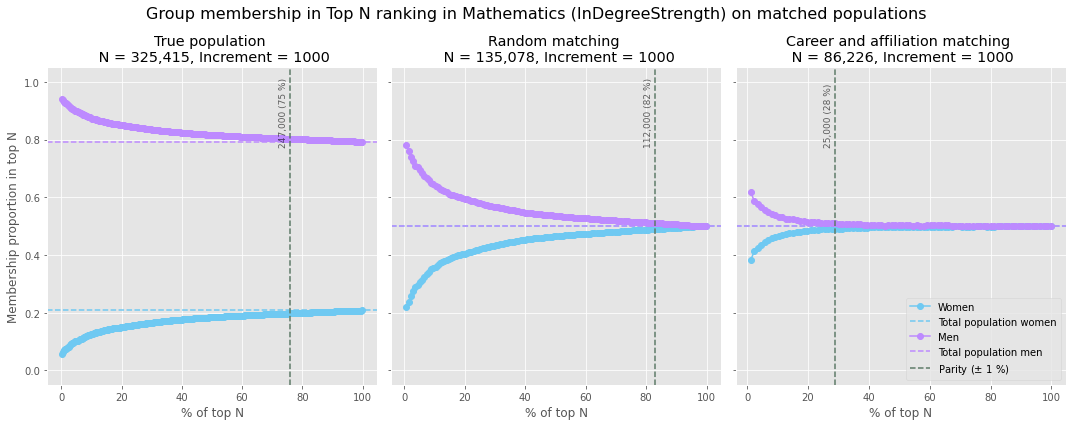

/home/laal/MAG/CentralityFairness/visualizations.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks)
/home/laal/MAG/CentralityFairness/visualizations.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks)


Full data median: 162707.0
Random data median: 176517.5
Matched data median: 159464.0


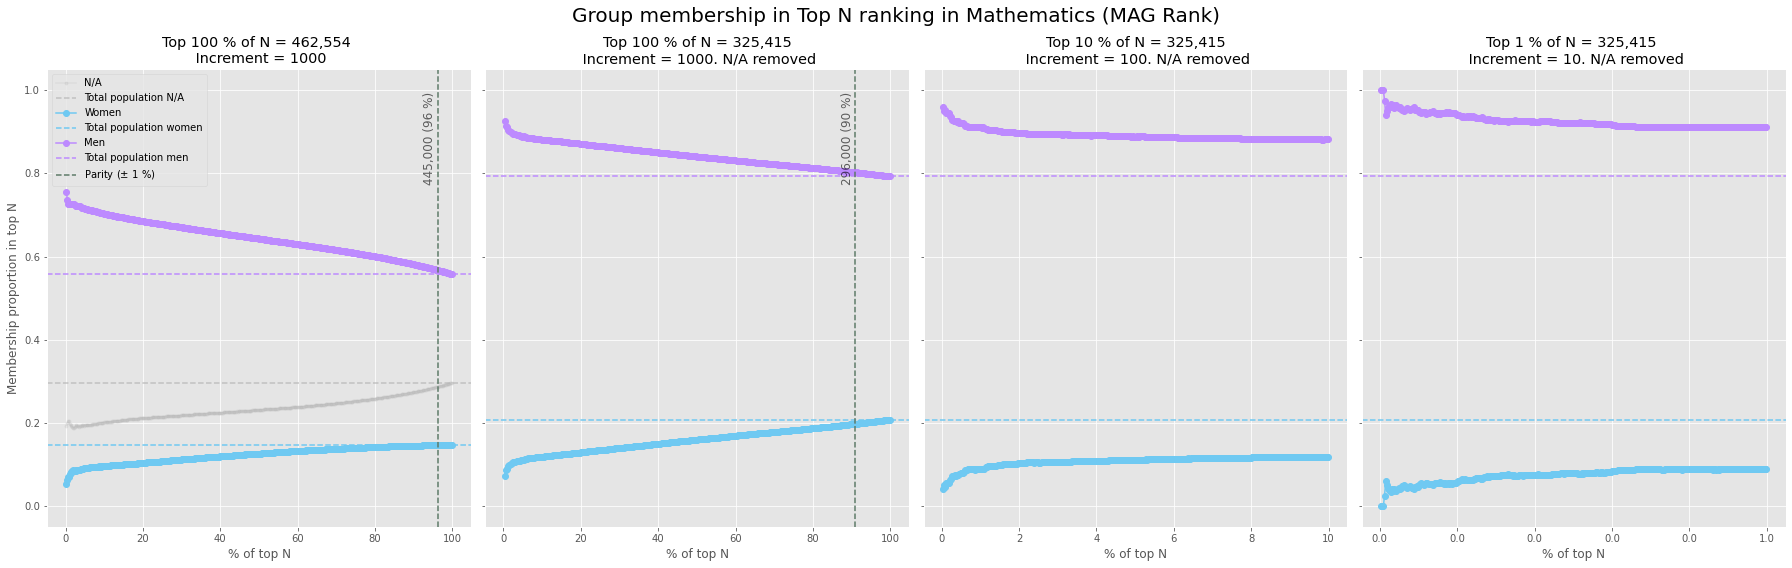

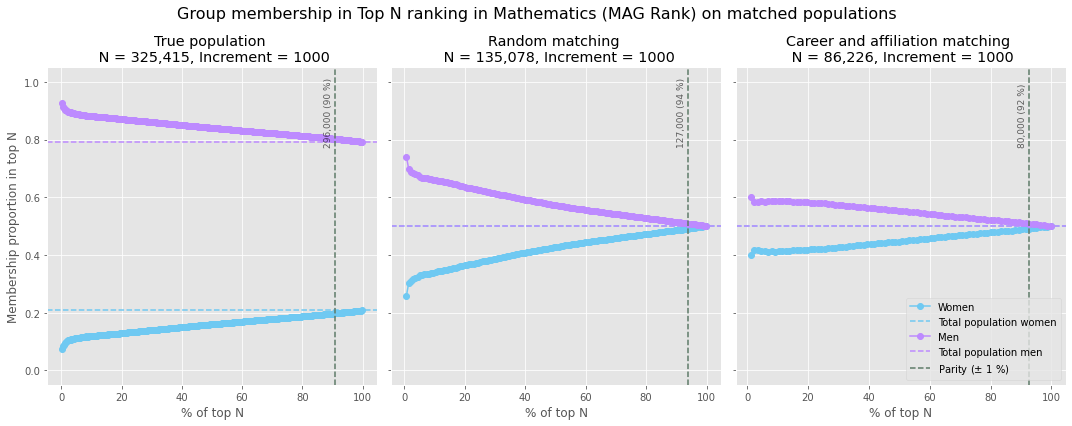

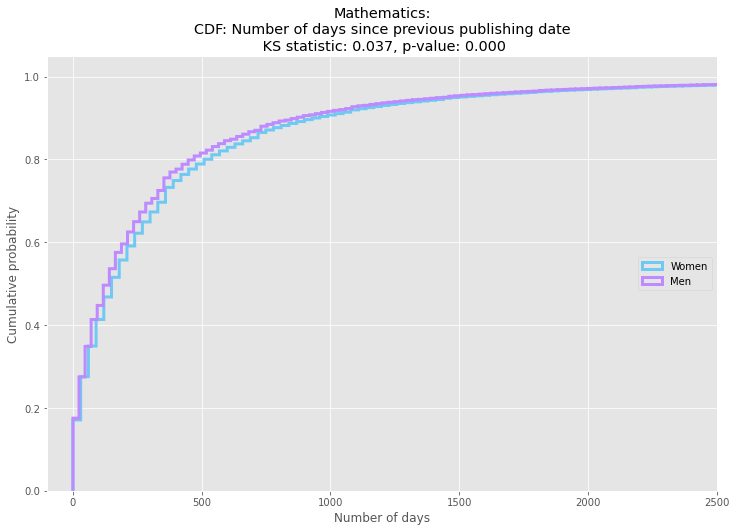

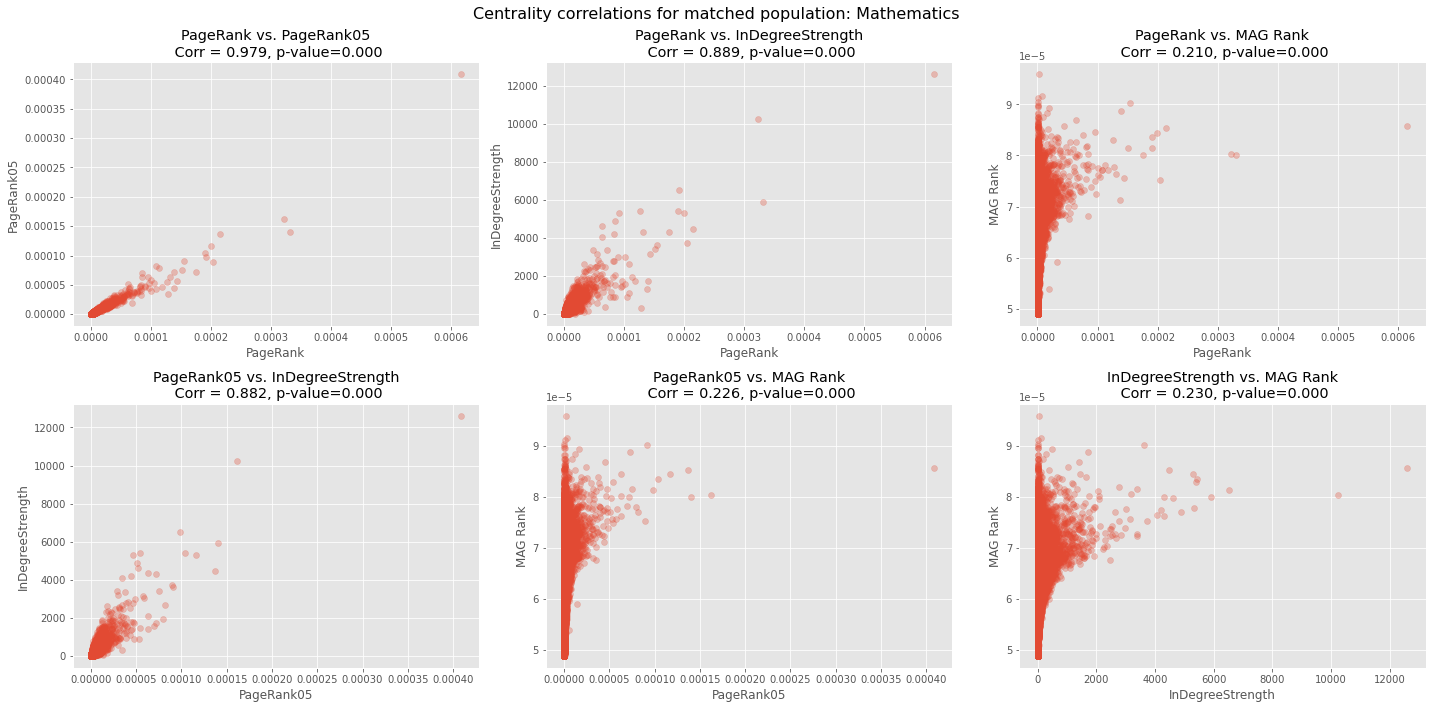

--------------------------------STARTING VIZ ON CHEMISTRY-----------------------------


gender counts before query:

1    1628636
0     978219
Name: Gender, dtype: int64
Men with more than 1 paper:  (914878, 12)
Women with more than 1 paper:  (508451, 12)


/home/laal/MAG/CentralityFairness/visualizations.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks)
/home/laal/MAG/CentralityFairness/visualizations.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks)


Full data median: 711664.0
Random data median: 736163.0
Matched data median: 594295.5


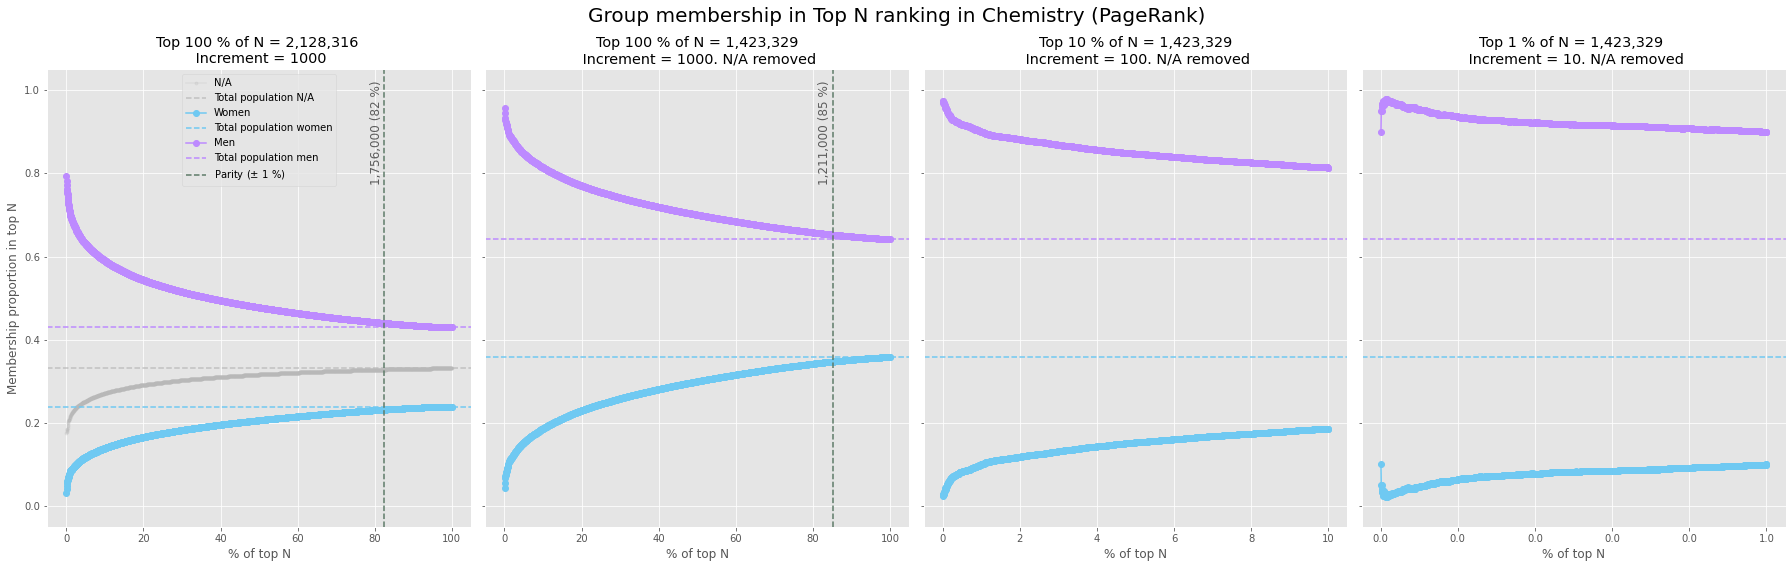

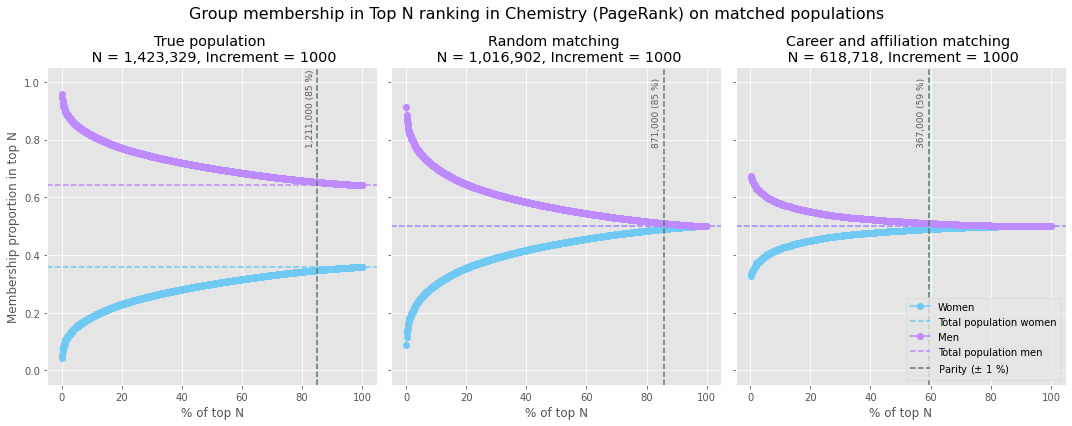

/home/laal/MAG/CentralityFairness/visualizations.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks)
/home/laal/MAG/CentralityFairness/visualizations.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks)


Full data median: 711664.0
Random data median: 734658.5
Matched data median: 602321.5


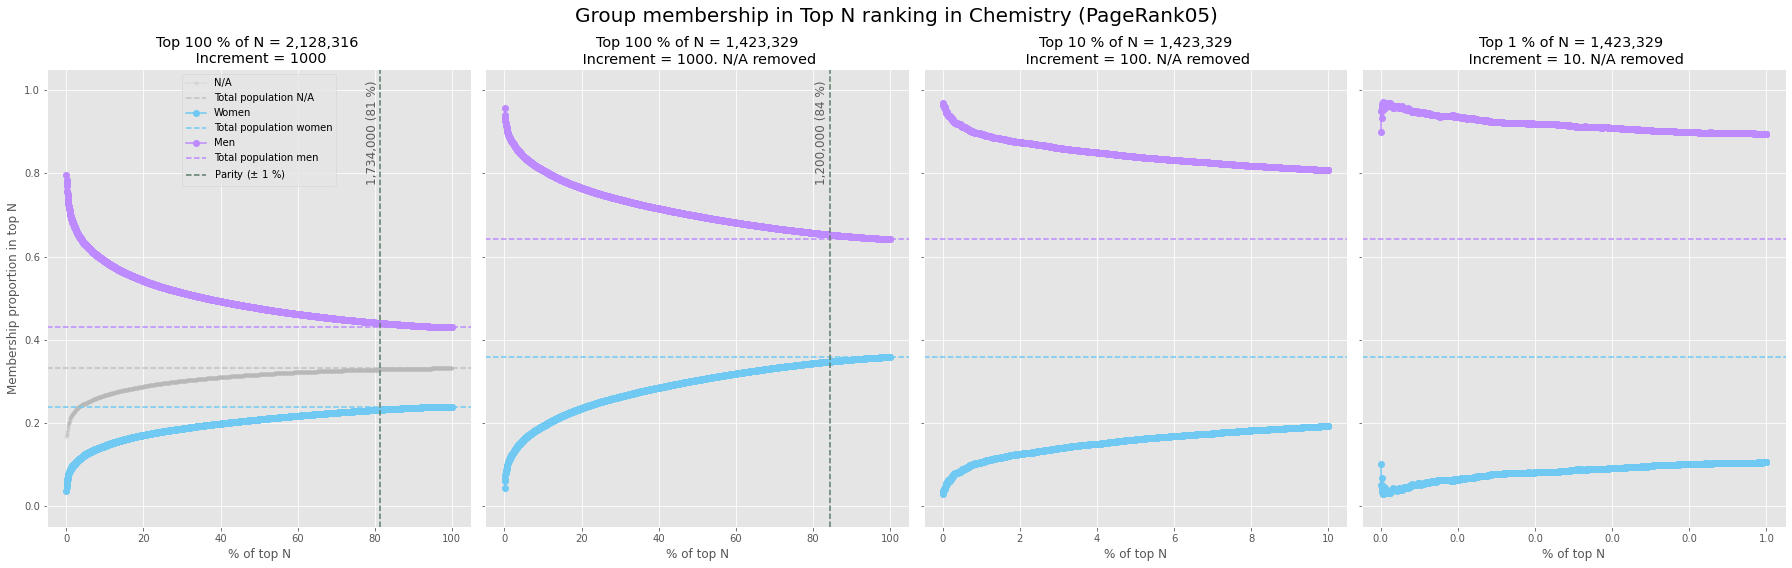

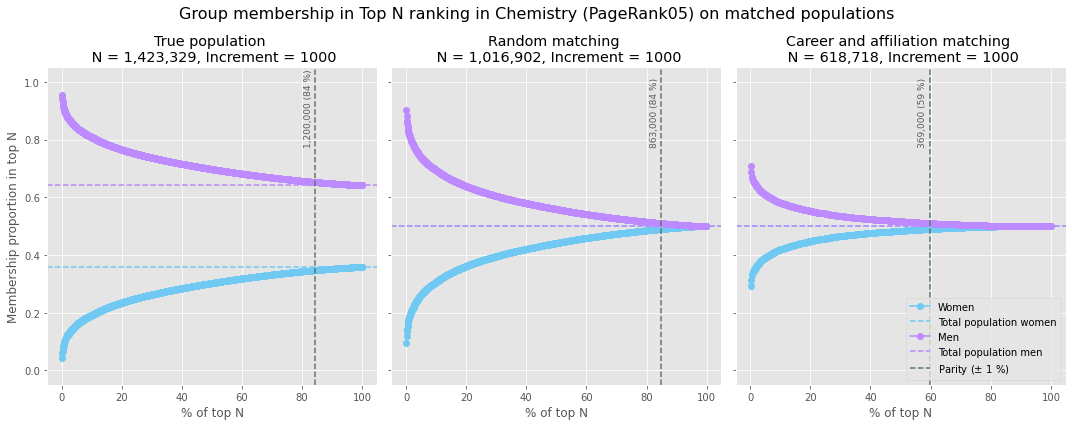

/home/laal/MAG/CentralityFairness/visualizations.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks)
/home/laal/MAG/CentralityFairness/visualizations.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks)


Full data median: 711664.0
Random data median: 727896.5
Matched data median: 597694.5


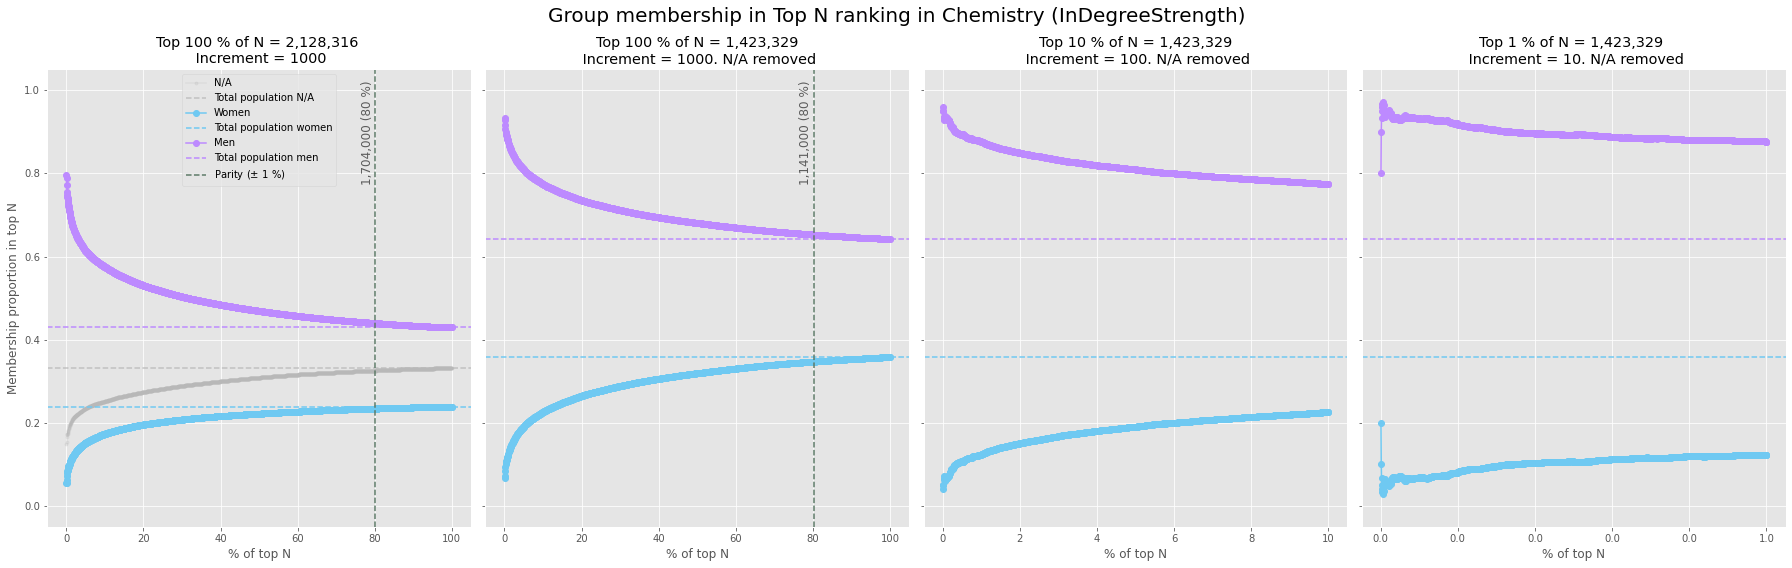

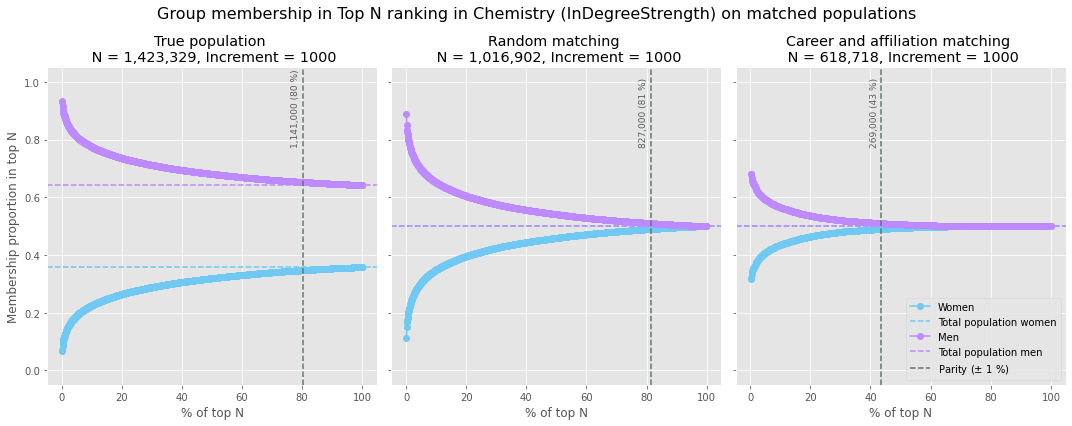

/home/laal/MAG/CentralityFairness/visualizations.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks)
/home/laal/MAG/CentralityFairness/visualizations.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks)


Full data median: 711664.0
Random data median: 741255.0
Matched data median: 652613.5


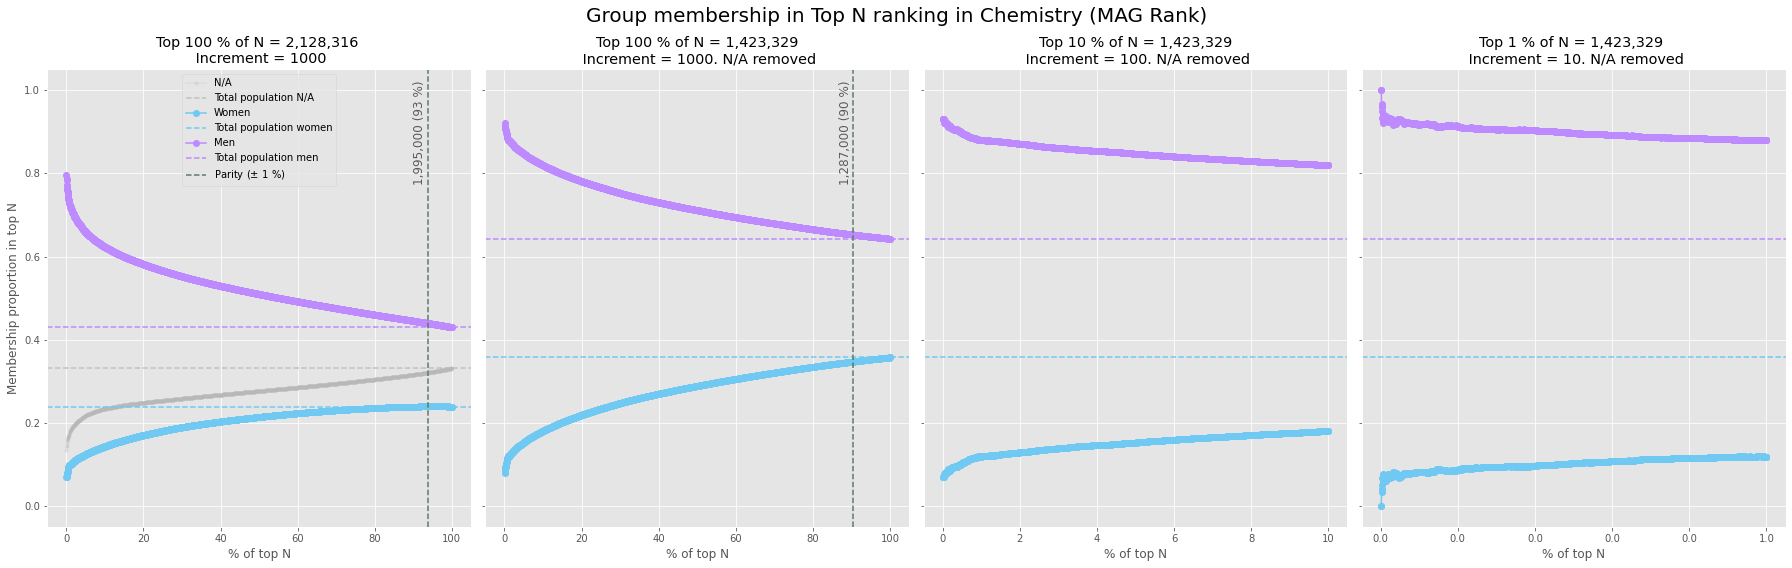

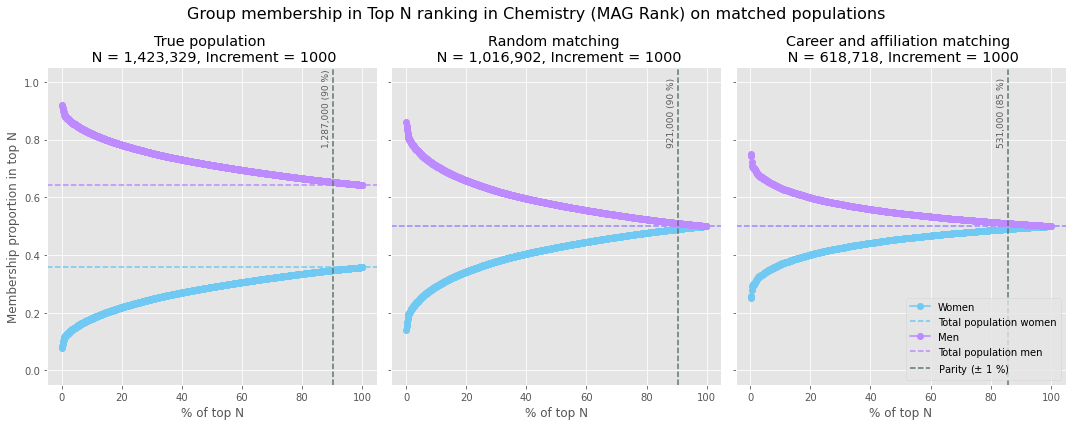

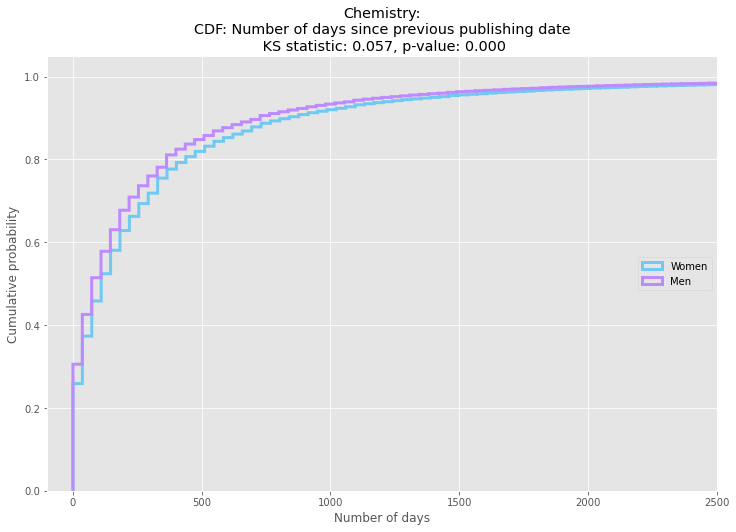

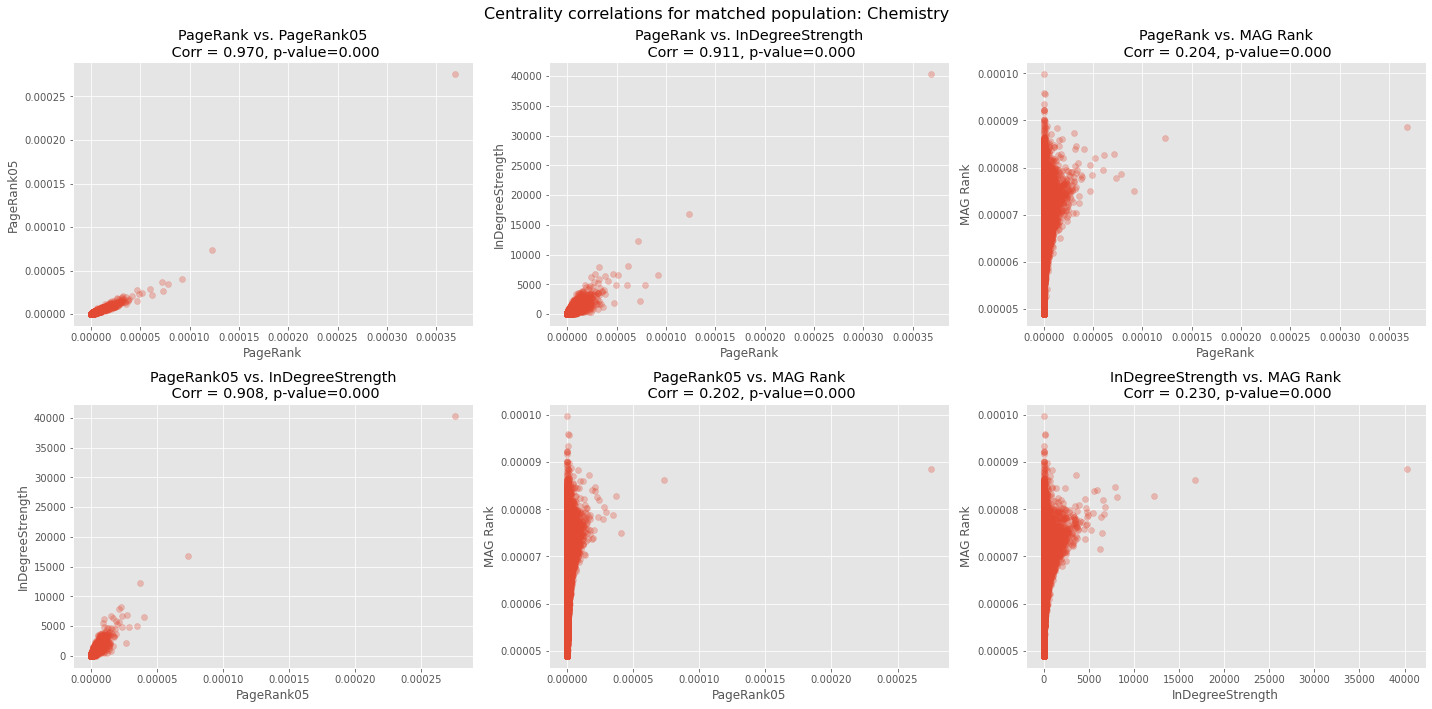

In [4]:
field_ids = {
        "Psychology": 15744967,
        "Economics": 162324750, 
        "Mathematics": 33923547,
        "Chemistry": 185592680,
    }
    
field_mapping = {
        "Economics": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightEconomics2020CentralityGendered.csv", 
        "Psychology": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightPsychology2020CentralityGendered.csv",
        "Mathematics": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightMathematics2020CentralityGendered.csv",
        "Chemistry": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightChemistry2020CentralityGendered.csv",
    }



for field_name, fpath in field_mapping.items():

    file_path = fpath
    field = field_name
    field_id = field_ids[field_name]
    base_filepath = "/home/laal/MAG"
    
    print("--------------------------------STARTING VIZ ON {}-----------------------------\n\n".format(field.upper()))

    destination = base_filepath + "/CentralityFairness/EVALUATIONS_OUTPUTS/matching_repeated_" + field + ".csv"

    data = pd.read_csv(file_path, sep="\t")
    matcher = Matcher(centrality_df = data, random_seed=0, field=field, base_filepath=base_filepath, fos_name=field)
    matcher.load_authors(fos_id=int(field_id), folder_destination = base_filepath + "/DATA/AuthorMetadataField.csv")


    random_data_males, random_data_females = matcher.random_sample()
    random_data = matcher.samples_to_centrality_data(random_data_males, random_data_females)

    
    #matched_data_males, matched_data_females = matcher.matched_sample()
    #matched_data = matcher.samples_to_centrality_data(matched_data_males, matched_data_females, store=True, is_matched=True)
    
    matched_data = pd.read_csv(base_filepath +  '/CentralityFairness/MATCHING_OUTPUTS/{}_seed0_matched.csv'.format(field_name), 
                               sep="\t")
    
    gendered_pop = pd.concat([matcher.male_population, matcher.female_population])
    unknown_population = matcher.unknown_population

    all_authors = list(gendered_pop.AuthorId.values) + list(unknown_population.AuthorId.values)
    
    centrality_raw = matcher.cent_df_raw[matcher.cent_df_raw.AuthorId.isin(all_authors)]
    
    matcher.save_visualizations(field=field, centrality_df=centrality_raw, random_centrality_df=random_data, 
                                matched_centrality_df=matched_data)
    
    datediffs, ks_test = compute_ks_test(mag, matched_data, fos_id=int(field_id), base_filepath="/home/laal/MAG/DATA")
    
    plot_inter_event_cdf(datediffs, ks_test, field, 
                         filepath=base_filepath +  '/CentralityFairness/EVALUATIONS_PLOTS/' + field + "_interevent_match_visualization.png"
                         )
    
    plot_centrality_correlations(field, matched_data, 
                                 filename=base_filepath +  '/CentralityFairness/EVALUATIONS_PLOTS/' + field + "_centrality_match_visualization.png"
                                )

In [5]:
random_data

,AuthorId,PageRank,PageRank05,InDegreeStrength,InDegree,OutDegreeStrength,OutDegree,Gender,Rank,MAG Rank
0,599318,1.142102e-07,1.859625e-07,3.787113,156.0,4.746717,132.0,1,16691,-16691
6,1258017,6.685116e-07,4.070817e-07,28.500000,60.0,10.000000,20.0,1,17764,-17764
11,2314789,3.317544e-07,3.832545e-07,89.791664,244.0,191.777770,555.0,0,18411,-18411
14,3381675,9.906518e-08,1.776322e-07,7.666666,31.0,37.833332,158.0,0,18399,-18399
17,3791134,8.603583e-08,1.625703e-07,3.333333,25.0,13.000000,73.0,1,16825,-16825
...,...,...,...,...,...,...,...,...,...,...
4069552,2764441952,1.676782e-06,1.228652e-06,270.638760,3046.0,146.290700,1042.0,1,15241,-15241
4069575,2764691920,1.473851e-07,2.101192e-07,15.500000,21.0,27.000000,28.0,1,17638,-17638
4069594,2764842062,2.502507e-06,1.528226e-06,708.844400,3629.0,823.329800,3168.0,0,15860,-15860
4069671,2765427208,9.325760e-08,1.692686e-07,5.833334,30.0,16.833334,84.0,1,18263,-18263


In [7]:
matched_data

,AuthorId,PageRank,PageRank05,InDegreeStrength,InDegree,OutDegreeStrength,OutDegree,Gender,Rank,MAG Rank
0,599318,1.142102e-07,1.859625e-07,3.787113,156.0,4.746717,132.0,1,16691,-16691
1,1671721,1.293839e-04,7.177190e-05,15316.099000,33599.0,3293.781000,5652.0,0,12736,-12736
2,2314789,3.317544e-07,3.832545e-07,89.791664,244.0,191.777770,555.0,0,18411,-18411
3,3381675,9.906518e-08,1.776322e-07,7.666666,31.0,37.833332,158.0,0,18399,-18399
4,3791134,8.603583e-08,1.625703e-07,3.333333,25.0,13.000000,73.0,1,16825,-16825
...,...,...,...,...,...,...,...,...,...,...
403069,2763912783,2.228208e-07,2.668803e-07,22.783333,140.0,23.750000,117.0,0,18679,-18679
403070,2764441952,1.676782e-06,1.228652e-06,270.638760,3046.0,146.290700,1042.0,1,15241,-15241
403071,2764842062,2.502507e-06,1.528226e-06,708.844400,3629.0,823.329800,3168.0,0,15860,-15860
403072,2765427208,9.325760e-08,1.692686e-07,5.833334,30.0,16.833334,84.0,1,18263,-18263


In [6]:
data.sort_values(by='PageRank', ascending=False, inplace=True)

In [7]:
data.reset_index(inplace=True)

In [8]:
data['rank_position'] = data.index

In [9]:
rank_position_df = data[['AuthorId', 'rank_position']]

In [11]:
matched_data.merge(rank_position_df, how='left', left_on='AuthorId', right_on='AuthorId')['rank_position'].median()

194170.5

In [21]:
data.query("AuthorId == 599318")

,index,AuthorId,PageRank,PageRank05,InDegreeStrength,InDegree,OutDegreeStrength,OutDegree,Gender,Rank,rank_position
999202,0,599318,1.142102e-07,1.859625e-07,3.787113,156.0,4.746717,132.0,1,16691,999202


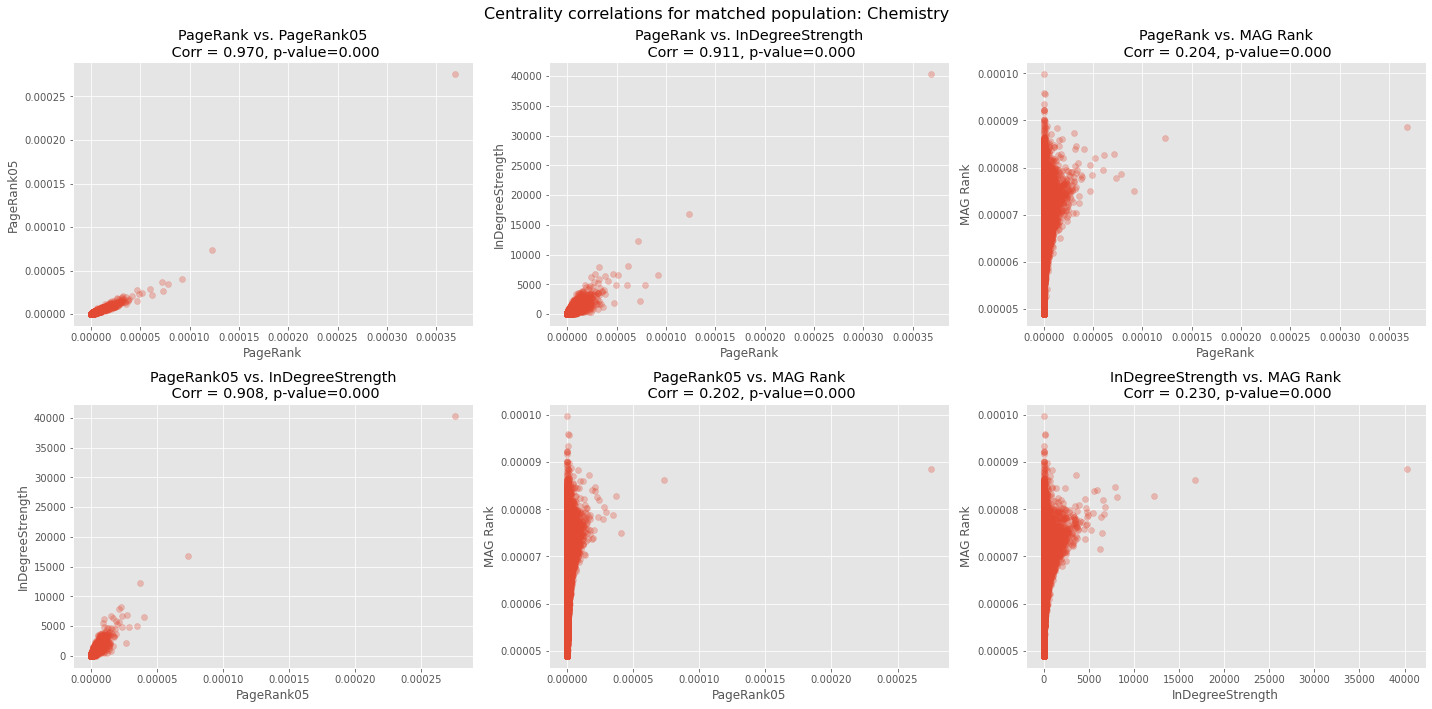

In [20]:
    plot_centrality_correlations(field, matched_data, 
                                 filename=base_filepath +  '/CentralityFairness/EVALUATIONS_PLOTS/' + field + "_centrality_match_visualization.png"
                                )

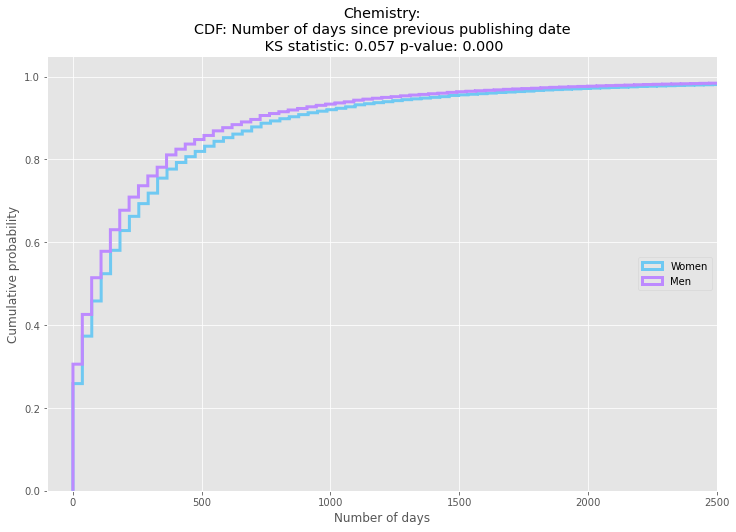

In [13]:
plot_inter_event_cdf(datediffs, ks_test, field, 
                         filepath=base_filepath +  '/CentralityFairness/EVALUATIONS_PLOTS/' + field + "_interevent_match_visualization.png"
                         )

In [14]:
matched_data.head()

,AuthorId,PageRank,PageRank05,InDegreeStrength,InDegree,OutDegreeStrength,OutDegree,Gender,Rank
0,233601,4.166827e-08,6.923541e-08,2.000000,31.0,8.75,8.75,0,19526
1,1219248,1.436565e-06,5.813267e-07,84.100000,280.0,12.00,12.00,0,16796
2,2966282,5.759584e-08,8.035252e-08,11.666667,70.0,0.00,0.00,0,17735
3,2968983,3.326690e-08,6.353323e-08,0.142857,3.0,0.00,0.00,1,17781
4,4326116,3.299666e-08,6.330171e-08,0.000000,0.0,13.65,13.65,0,18418


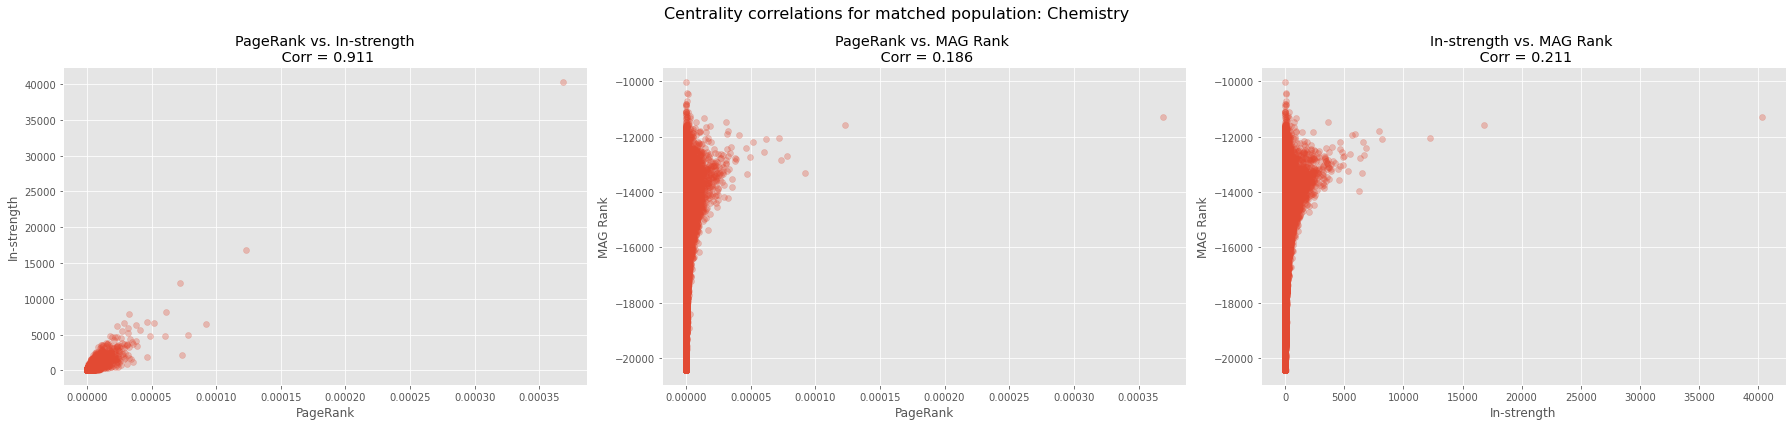

In [27]:
matched_data.corr()

,AuthorId,PageRank,PageRank05,InDegreeStrength,InDegree,OutDegreeStrength,OutDegree,Gender,Rank
AuthorId,1.000000,-0.018429,-0.019479,-0.034810,-0.051948,-0.065785,-0.065785,0.028238,0.150253
PageRank,-0.018429,1.000000,0.969916,0.911160,0.769339,0.417571,0.417571,0.027620,-0.185903
PageRank05,-0.019479,0.969916,1.000000,0.907890,0.758926,0.388834,0.388834,0.026913,-0.184294
InDegreeStrength,-0.034810,0.911160,0.907890,1.000000,0.873270,0.620611,0.620611,0.029585,-0.211196
InDegree,-0.051948,0.769339,0.758926,0.873270,1.000000,0.636883,0.636883,0.030225,-0.326609
OutDegreeStrength,-0.065785,0.417571,0.388834,0.620611,0.636883,1.000000,1.000000,0.034818,-0.255643
OutDegree,-0.065785,0.417571,0.388834,0.620611,0.636883,1.000000,1.000000,0.034818,-0.255643
Gender,0.028238,0.027620,0.026913,0.029585,0.030225,0.034818,0.034818,1.000000,-0.113721
Rank,0.150253,-0.185903,-0.184294,-0.211196,-0.326609,-0.255643,-0.255643,-0.113721,1.000000


In [29]:
scipy.stats.pearsonr(matched_data['PageRank'], matched_data['InDegreeStrength'])

(0.9111600755450289, 0.0)

In [10]:
ks_2samp([1,2,3,4,5], [2,3,4,5,6]).pvalue

1.0

In [9]:
ks_2samp([1,2,3,4,5], [2,3,4,5,6])

KstestResult(statistic=0.2, pvalue=1.0)